# **MIT 6.S085: Machine Learning for Molecular Design**

# Lecture 2: Data Processing and Analysis

Lecturer: Ron Shprints

Date: 01/10/2024

Note: In this notebook we will review several common methods in unsupervised learning. We will focus on dimensionality reduction and clustering, which are very common methodologies in molecular design.

# Agenda

0. Paper Review
1. Unsupervised Learning
2. PCA
3. Feature Selection
4. t-SNE
5. Clustering
6. Research Problem

**Go to File>Save a copy in Drive, and work on your local copy**

Run the following cells to install and import all the required packages to run this notebook:

In [ ]:
!pip install chembl_webresource_client # Installation of ChEMBL for section 2 (PCA)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 875.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 23.2.0
    Uninstalling attrs-23.2.0:
      Successfully uninstalled attrs-23.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
jsonschema 4.19.2 requires attrs>=22.2.0, but you have attrs 21.4.0 which is incompatible.
referencing 0.32.0 requires attrs>=22.2.0, but you have attrs 21.4.0 which is incompatible.


In [ ]:
!pip install deepchem # Installation of deepchem to load the Delaney dataset in section 3 (t-SNE)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
jax 0.4.23 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.
jaxlib 0.4.23+cuda12.cudnn89 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.


In [ ]:
from chembl_webresource_client.new_client import new_client # Importing ChEMBL for section 2 (PCA)

# section 3 (t-SNE) imports:

import deepchem as dc
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE

# general imports:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


# 0. Paper Review

1. **Mapping the space of chemical reactions using attention-based neural networks** ([link](https://www.nature.com/articles/s42256-020-00284-w))

Philippe Schwaller, Daniel Probst, Alain C. Vaucher, Vishnu H. Nair, David Kreutter, Teodoro Laino & Jean-Louis Reymond

Nature 2021

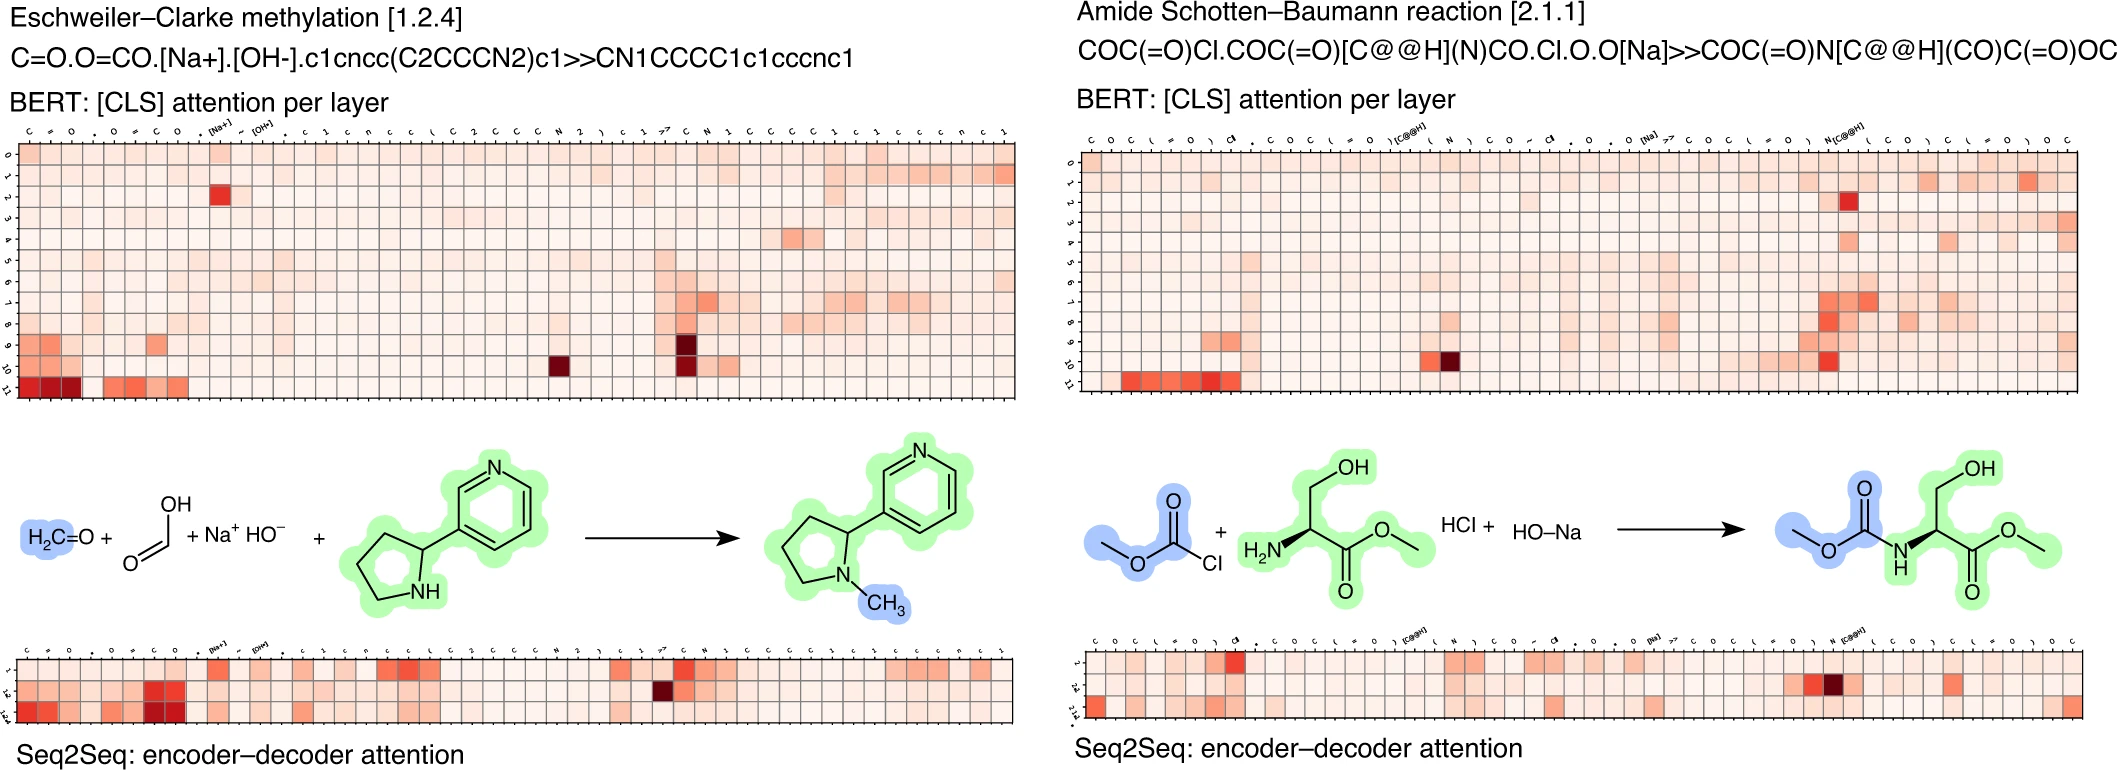


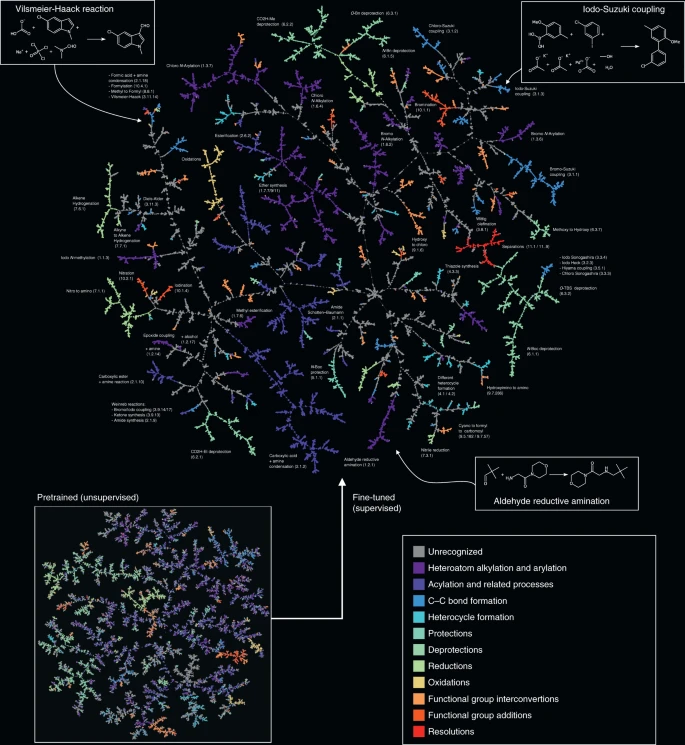

2. **The art of using t-SNE for single-cell transcriptomics** ([link](https://www.nature.com/articles/s41467-019-13056-x))

Dmitry Kobak & Philipp Berens

Nature 2019

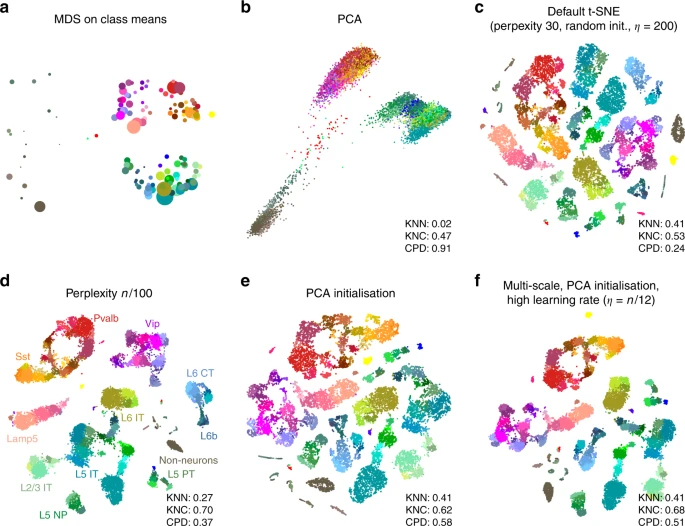

# 1. Unsupervised Learning

🟠 ***Introduction***


---


Unsupervised learning is a type of machine learning that deals with **unlabeled data**. Unlike supervised learning, where the goal is to learn from a dataset that includes labeled examples (i.e., input-output pairs), unsupervised learning aims to **find patterns or structures within a dataset without the guidance of explicit labels or outputs**.

Today we will learn about two main problems in unsupervised learning: **dimensionaliy reduction** and **clustering**.


Something to keep in mind:

Since there are no explicit labels, it can be challenging to determine the effectiveness of the learning process. The interpretation of results is often subjective and depends on the context of the data.

# 2. Principal Component Analysis (PCA)

🔵***Background Story***


---


In drug discovery, one of the most vital steps includes screening a library of molecules and testing whether one (or some) of them is likely to be an effective drug. Experimental screening usually requires **a lot of time and expensive resources**. Therefore, being able to **predict the drug likeliness** of molecules is an important task in drug discovery.

For this task you construct a dataset outlining **as much information as possible about the candidate molecules**. You can specify their molecular weights, the functional groups in each molecule, toxicities, and number of rings. You can even conduct a market survey to figure out whether some of them were used in the past as drugs for another disease.

The bottom line is: **You have many variables to consider in the prediction task**.

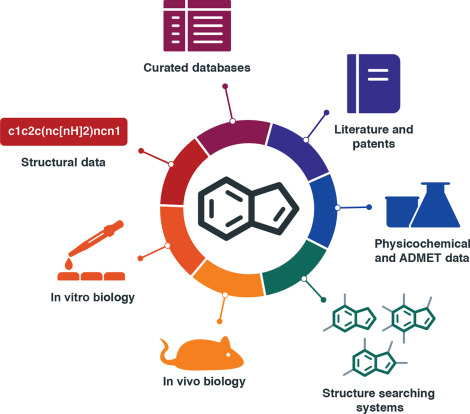

🔵***Problem Formulation***


---



*   Let $X_i=(X_i^{(1)}, X_i^{(2)},...,X_i^{(d)})$ be a $d$-dimensional vector describing the $i$-th drug in the dataset.
*   Denote by $\mathbb{X}$ the $n\times d$ matrix:



$$\mathbb{X} = \begin{pmatrix} \cdots & X_1^T & \cdots\\
\cdots & X_2^T & \cdots\\
& \vdots & \\
\cdots & X_n^T & \cdots\\ \end{pmatrix}$$






🟠***Why Is This a Problem?***


---

1. You need to make sure that you **understand the relationship between the variables**. This can be quite challenging for our particular task. For example, perhaps the molecular weight is correlated with toxicity? Idealy, we would like to work with **independent variables** to avoid redundant information.

2. Too much information can make the prediction task more challenging to the model. It's very likely that at some point the model will just **overfit** to the training data and won't be able to generalize well.

🔵 ***Organizing the Plan: Working with the Dataset and Context***


---

Before we jump into the computational solution, it's crucial to **fully understand the problem**! For example, maybe some of the variables in the dataset aren't even relevant for our task (for example, maybe the dataset contains the molecule's serial number, which is irrelevant for our task).



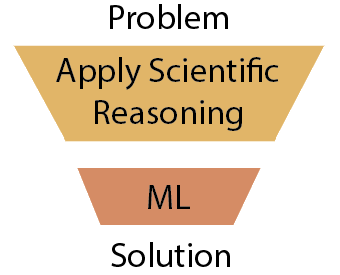







In this lecture, we are going to work with the ChEMBL database:

> "*ChEMBL is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs.*"


As you can see by running the code cells below, each molecule in the dataset is charactarized by numeruous features that describe its properties. To reduce the number of features that we consider for our downstream task, we will only consider the parameters for the [Lipinski Rule of 5](https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five), which is a rough characterization of drug-like molecules. As specified in the linked source:



> Lipinski's rule states that, in general, an orally active drug has no more than one violation of the following criteria:
* No more than 5 hydrogen bond donors (the total number of nitrogen-hydrogen and oxygen-hydrogen bonds)
* No more than 10 hydrogen bond acceptors (all nitrogen or oxygen atoms)
* A molecular mass less than 500 daltons
* A calculated octanol-water partition coefficient (Clog P) that does not exceed 5

> Note that all numbers are multiples of five, which is the origin of the rule's name. As with many other rules of thumb, such as Baldwin's rules for ring closure, there are many exceptions.



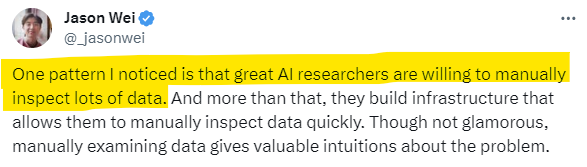

⚫ ***Coding Task***


---

Run the cells below and take a look at the available features. Looking at the dataset before we throw it on some magical machine learning mode is super important!



In [ ]:
# Define the query parameters for Lipinski's Rule of Five
filters = {
    'num_lipinski_ro5_violations': 0
}

# Query the ChEMBL database
molecules = new_client.molecule.filter(**filters)

for mol in molecules[:10]:  # Inspect 10 molecules for demonstration
    print(mol['molecule_chembl_id'], mol['molecule_properties'])

🟠***Possible Solutions***


---

1. **Feature Elimination:** Instead of considering every single variables that we have in the dataset, choose the top $k$ varaibles that you think are the **best predictors for the downstream task**. The obvious disadvantage here is that by eliminating the other variables we **completely ignore** any information that they might provide.

2. **Feature Extraction:** The high level idea is that we create **new independent variables**, where each new independent variable is **some combination of the old variables**. The crucial point is that we make these new variables in a specific way that allows us to account for their relative importances. So where is the dimensionality reduction here? Well, we can keep as many of the new variables as we want! Because they are all a combination of the old variables we're still keeping all of the information. However, now we're weighting the old variables according to their relative importances.

🟠***What Is PCA?***


---

PCA is a technique for **feature extraction**. It allows us to build new independent variables while retaining the information from all the old variables.


You should use PCA if you answered "Yes" to **all** of these questions [1]:

1. Do you want to reduce the number of variables, but aren't able to identify variables to completely remove from consideration?

2. Do you want to ensure your variables are independent of one another?

3. Are you comfortable making your independent variables less interpretable?

The third question is usally a great sacrafice, and you **should not** use PCA if you answered "No" to that question [1].

🟠***How Does PCA Work?***

---

Conceptually, we can think about PCA as an iterative algorithm. We start by finding a vector with the direction and magnitude that **best explains the observed data**. Then, we find the second best vector that explains the data with the **constraint that it's orthogonal to the first principal component**. We continue in this way...


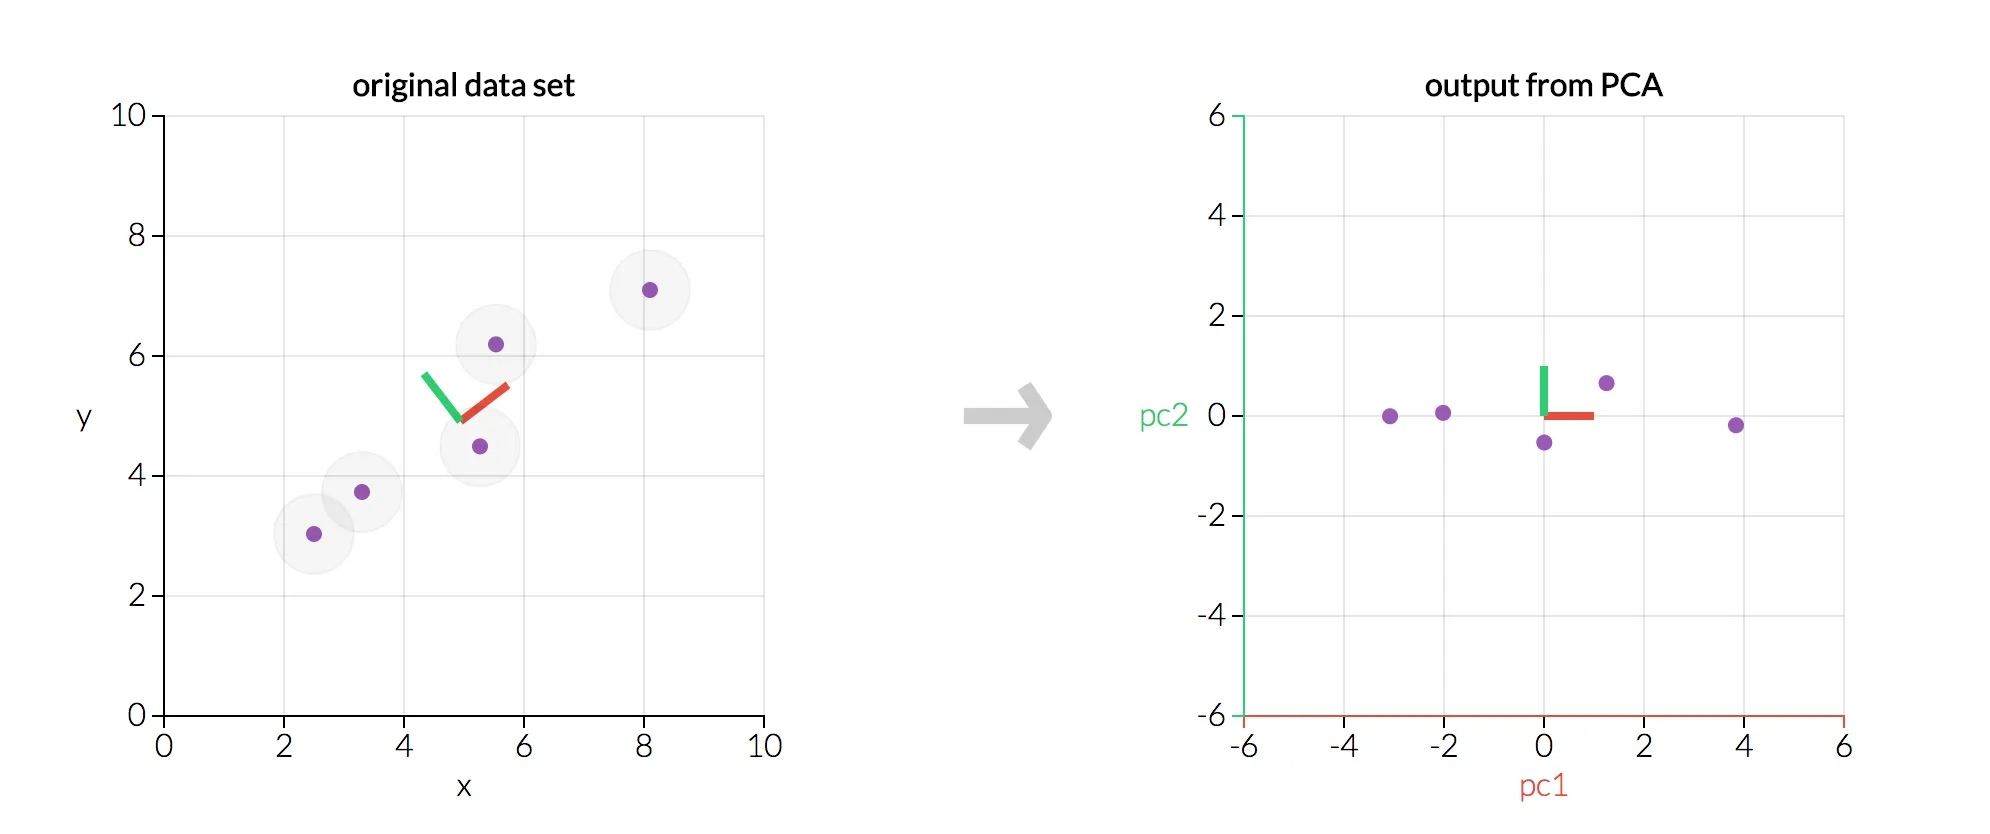



(image: [1])






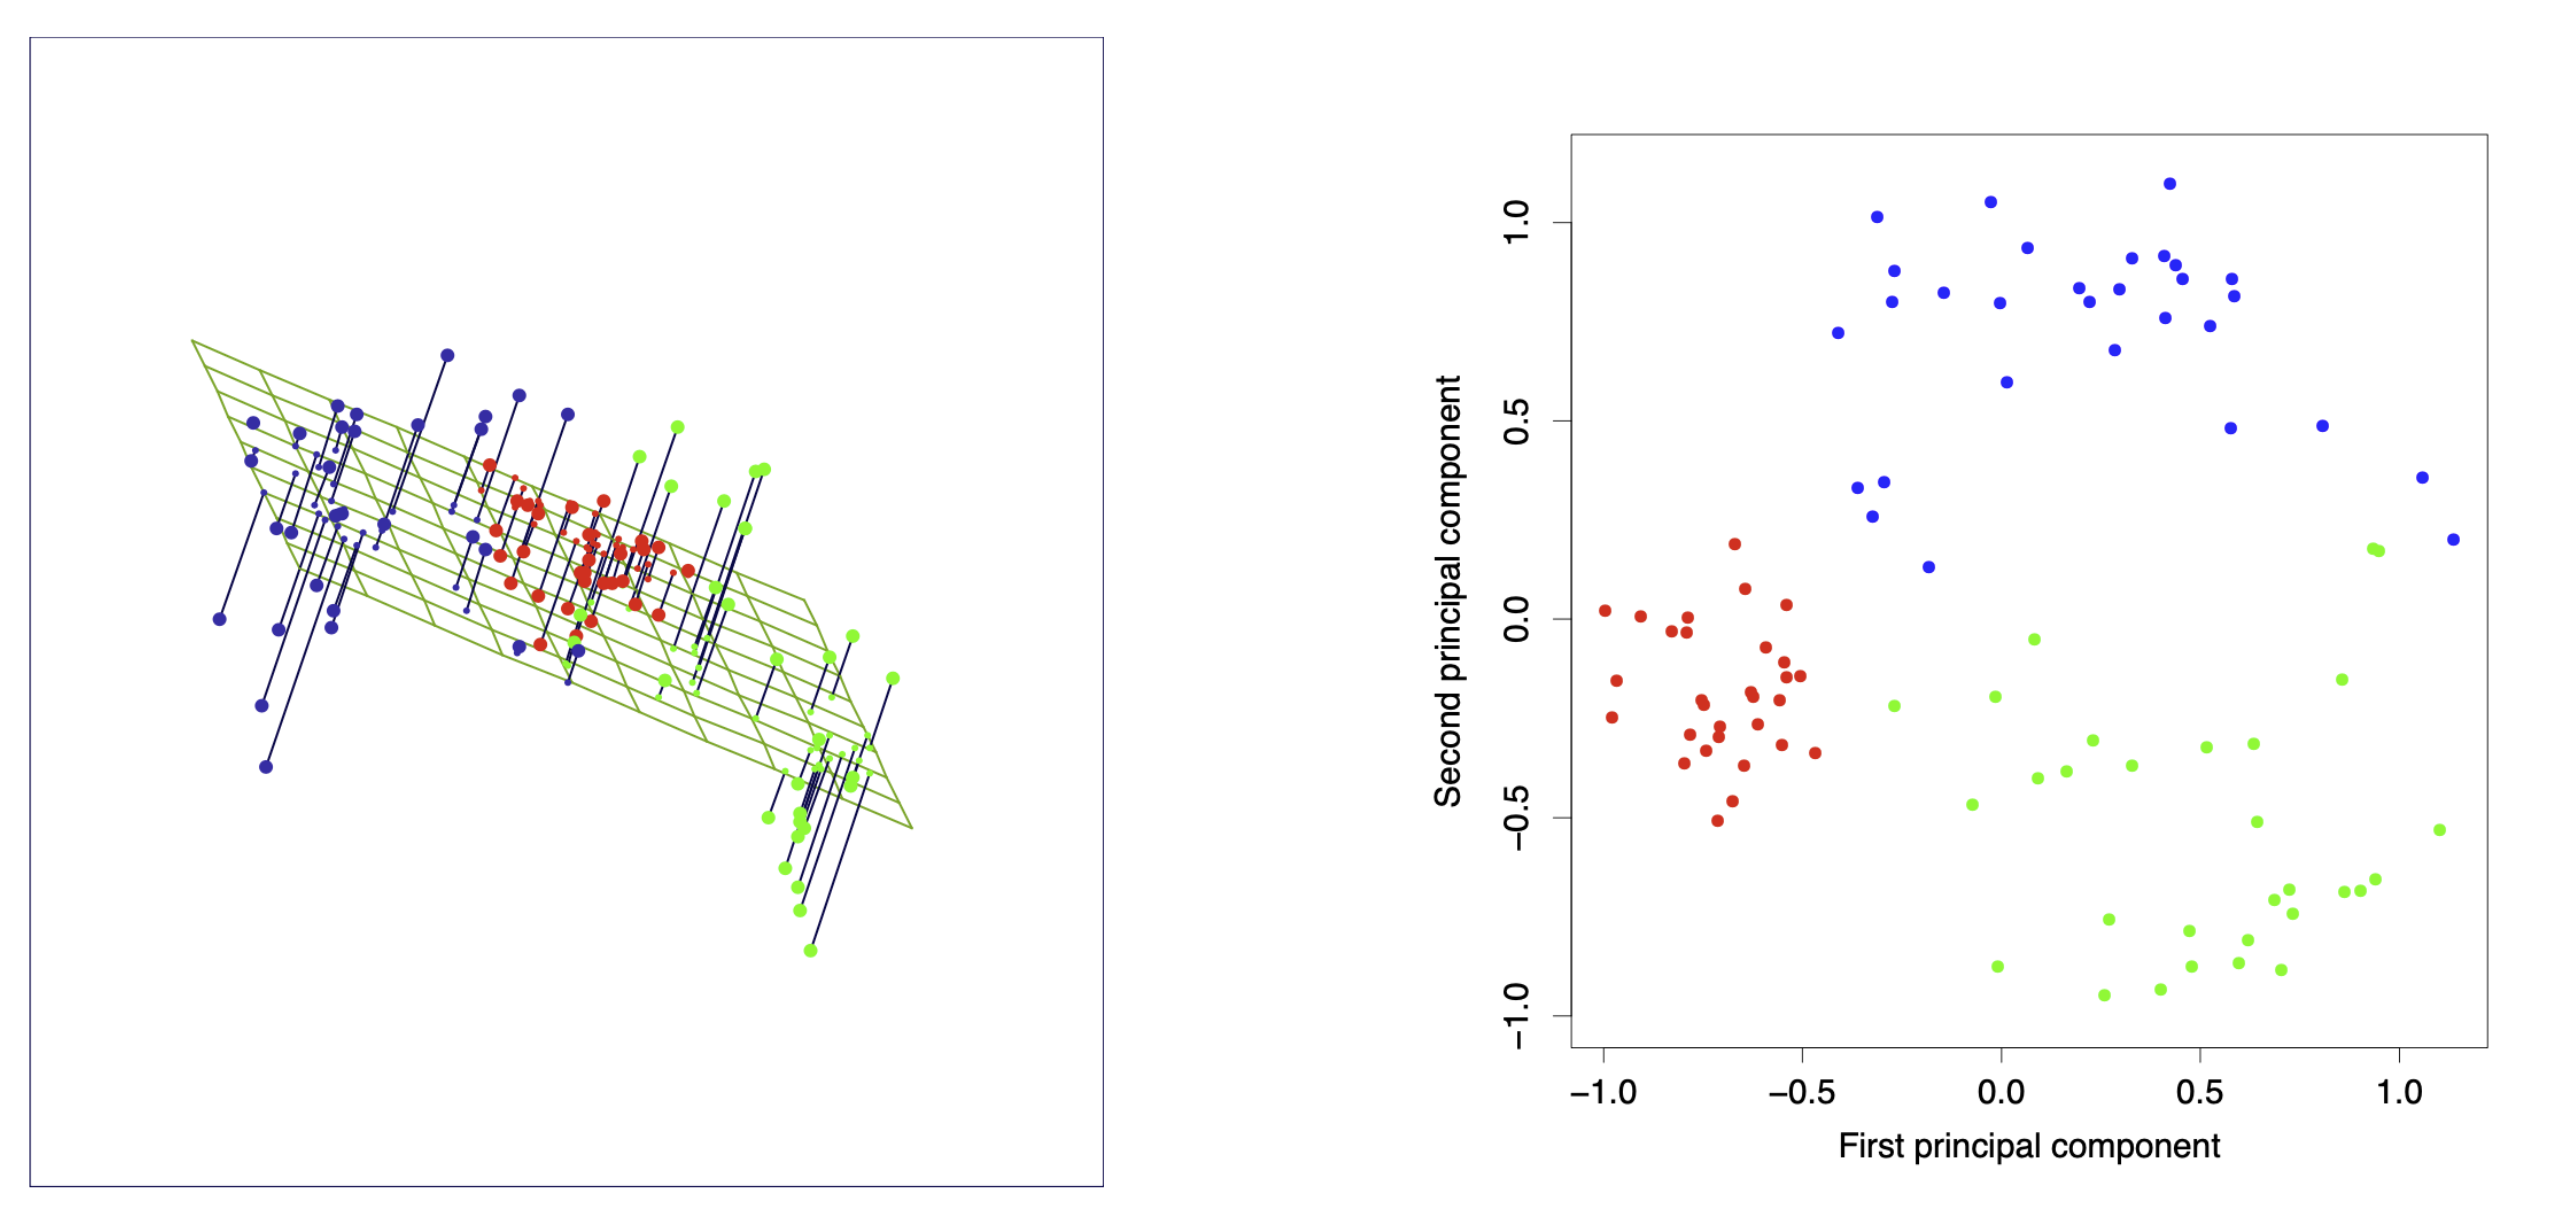














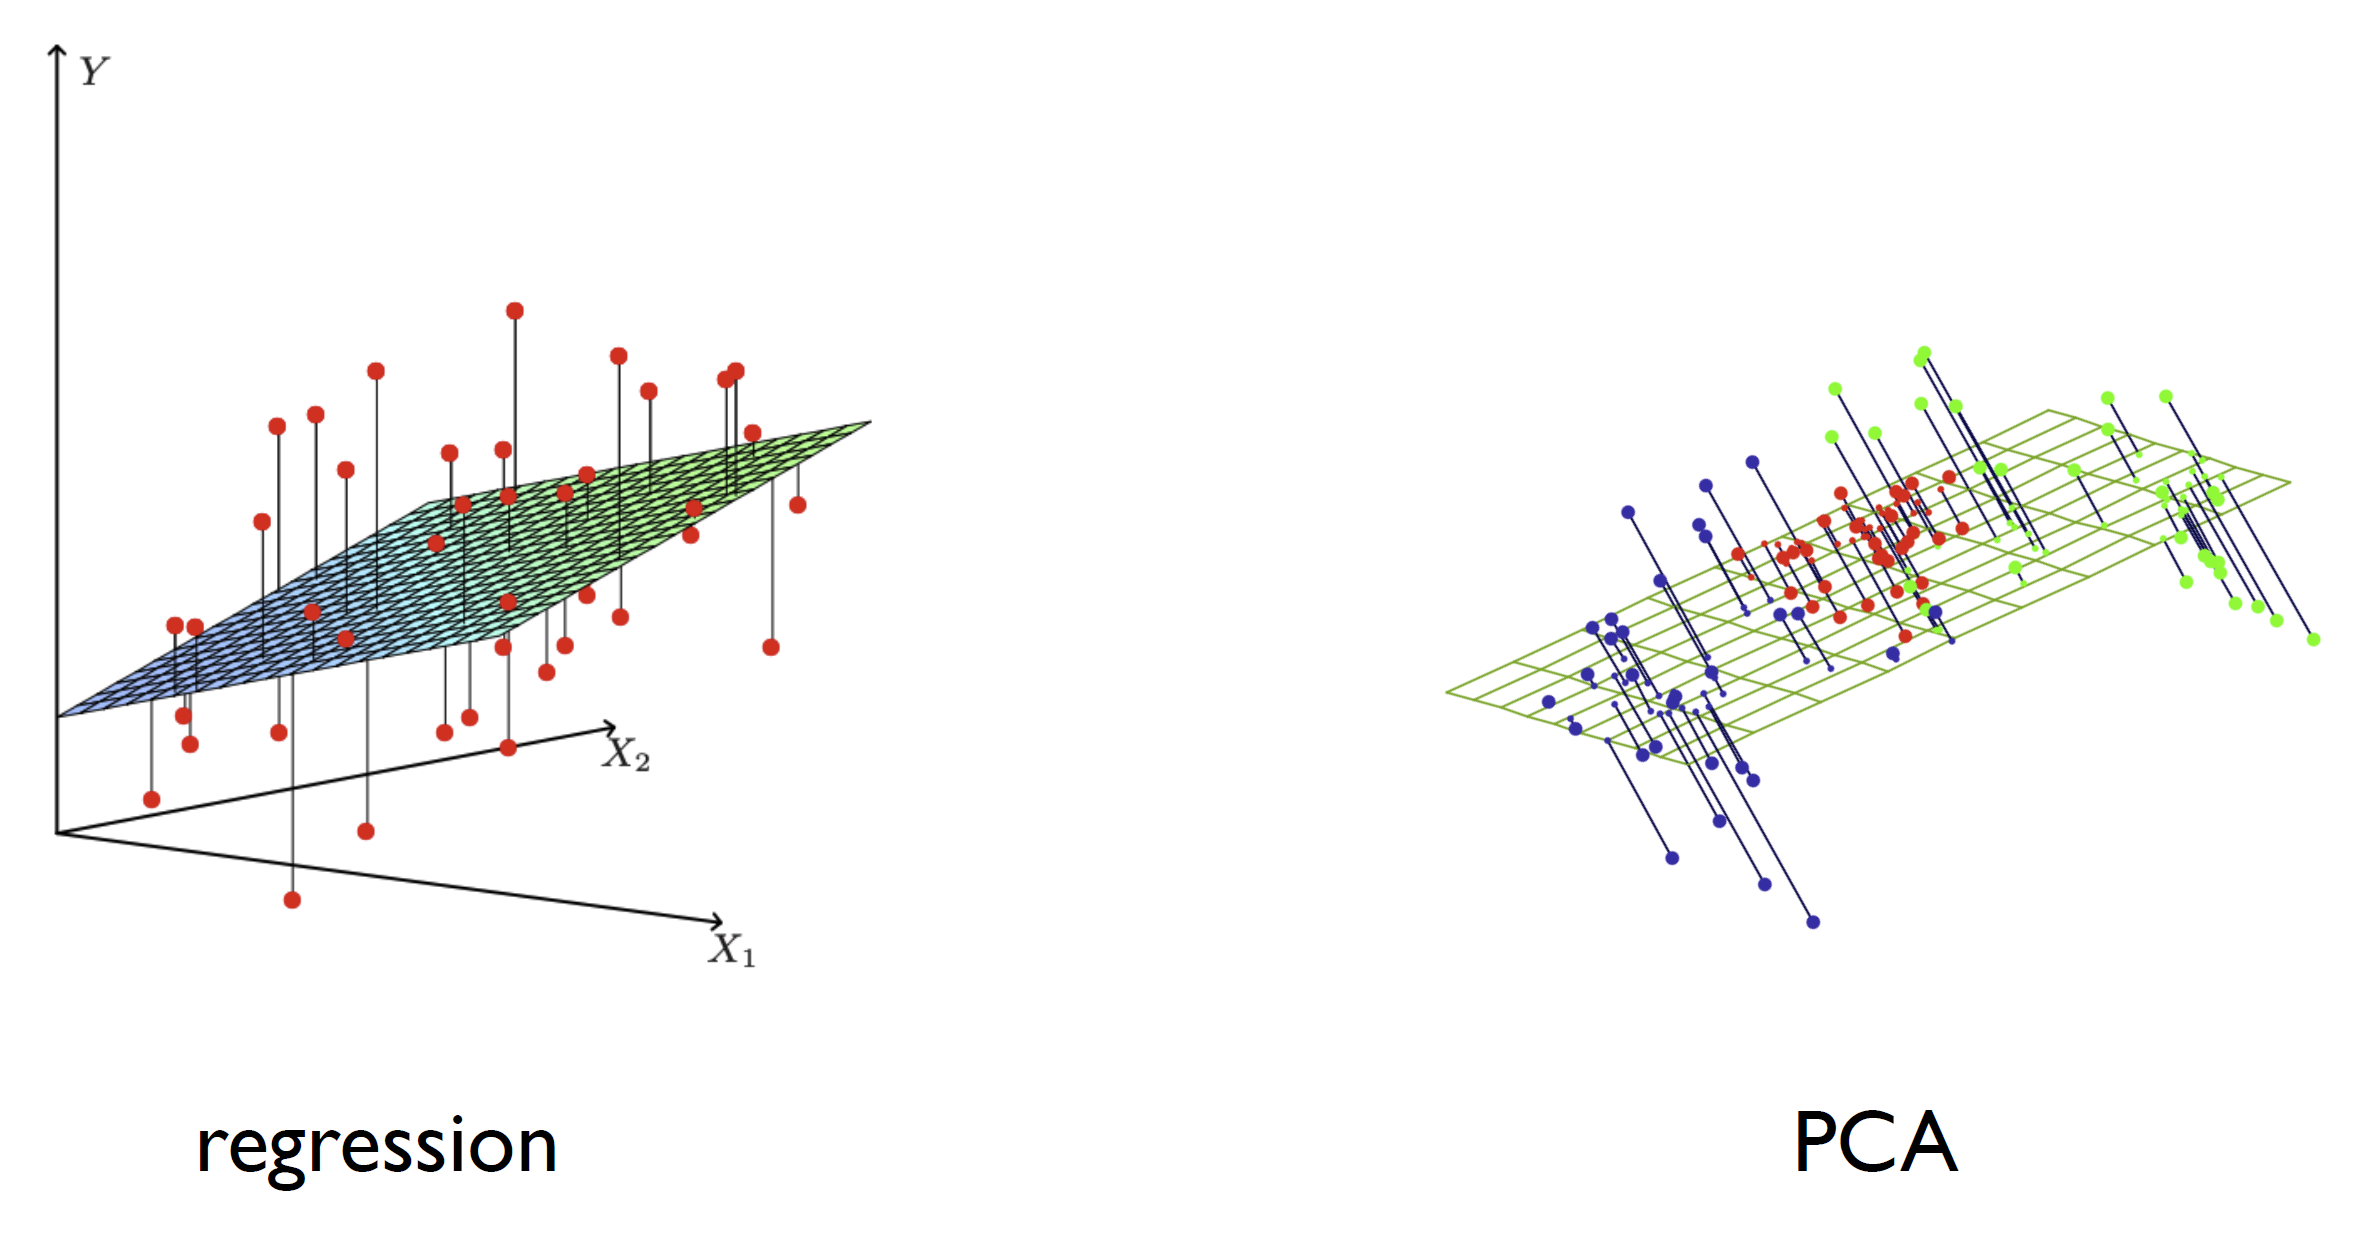

(image: Hastie, Tibshirani, Friedman)

🟣 ***Example of PCA***


---

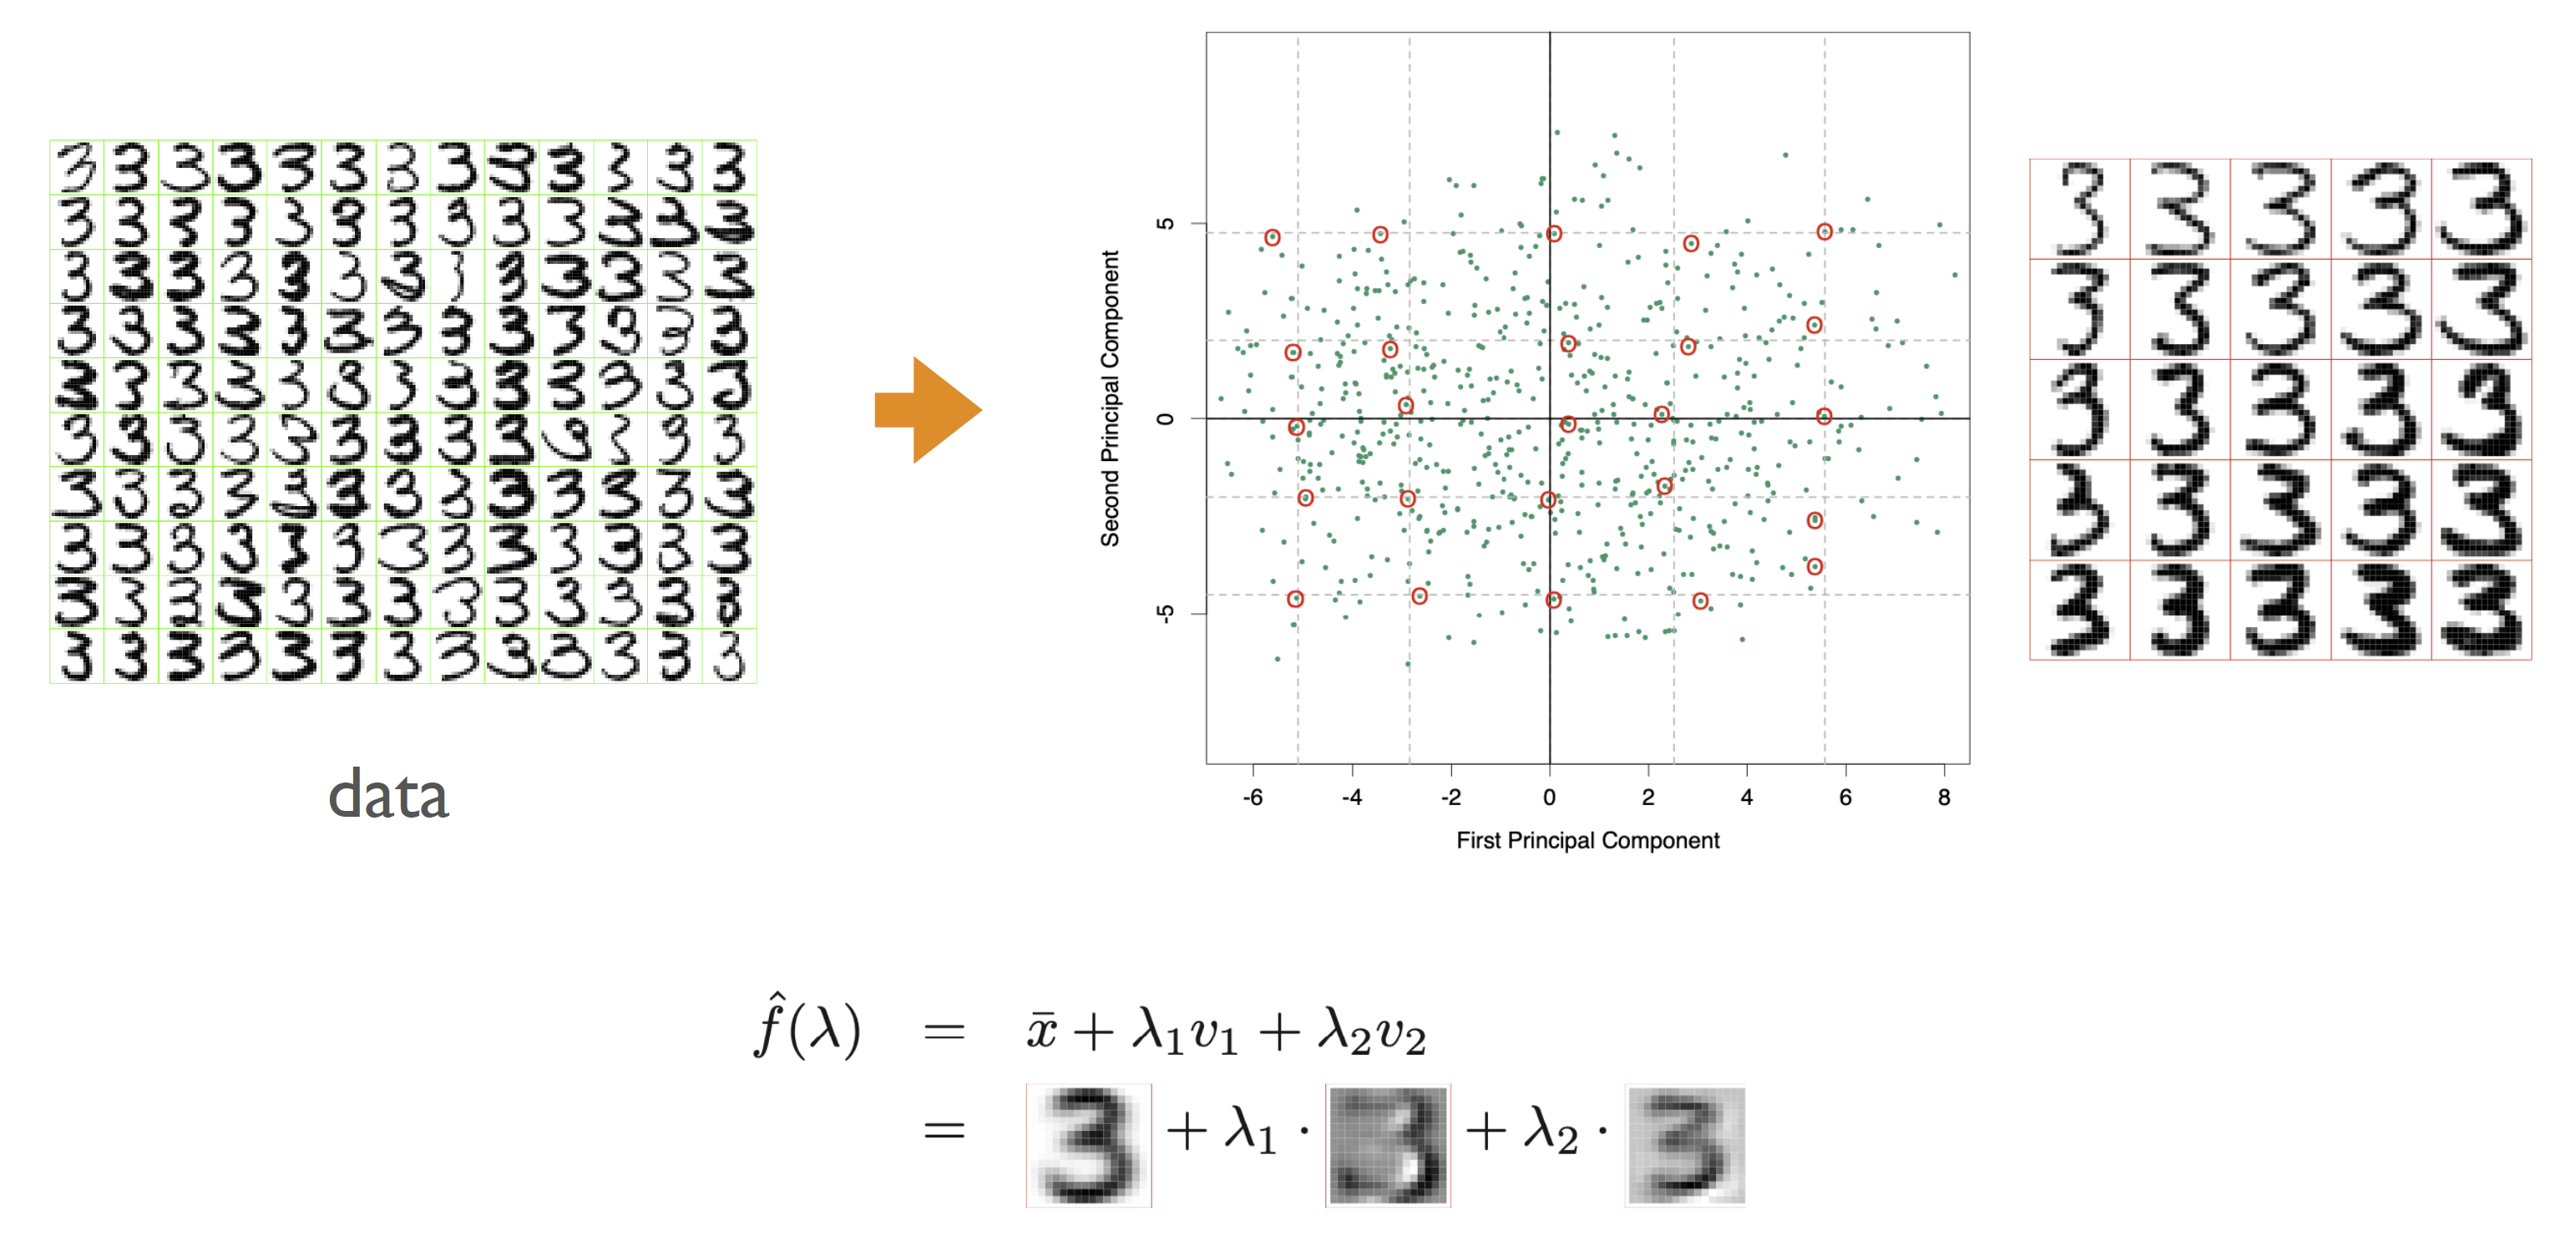

(image: Hastie,  Tibshirani, Friedman)


🔴***Algorithm 1: PCA from SVD***


---

🟣**Fact (Singular Value Decomposition, SVD).** $\mathbb{X}\in \mathbb{R}^{n\times d}$ can always be written as $\mathbb{X}=UDV^T$, with $D\in \mathbb{R}^{d\times d}$ with diagonal entries $d_1\geq d_2 \geq ... \geq d_d \geq 0$. $U$ and $V$ are orthonormal (i.e., $U^TU=V^TV=I$).

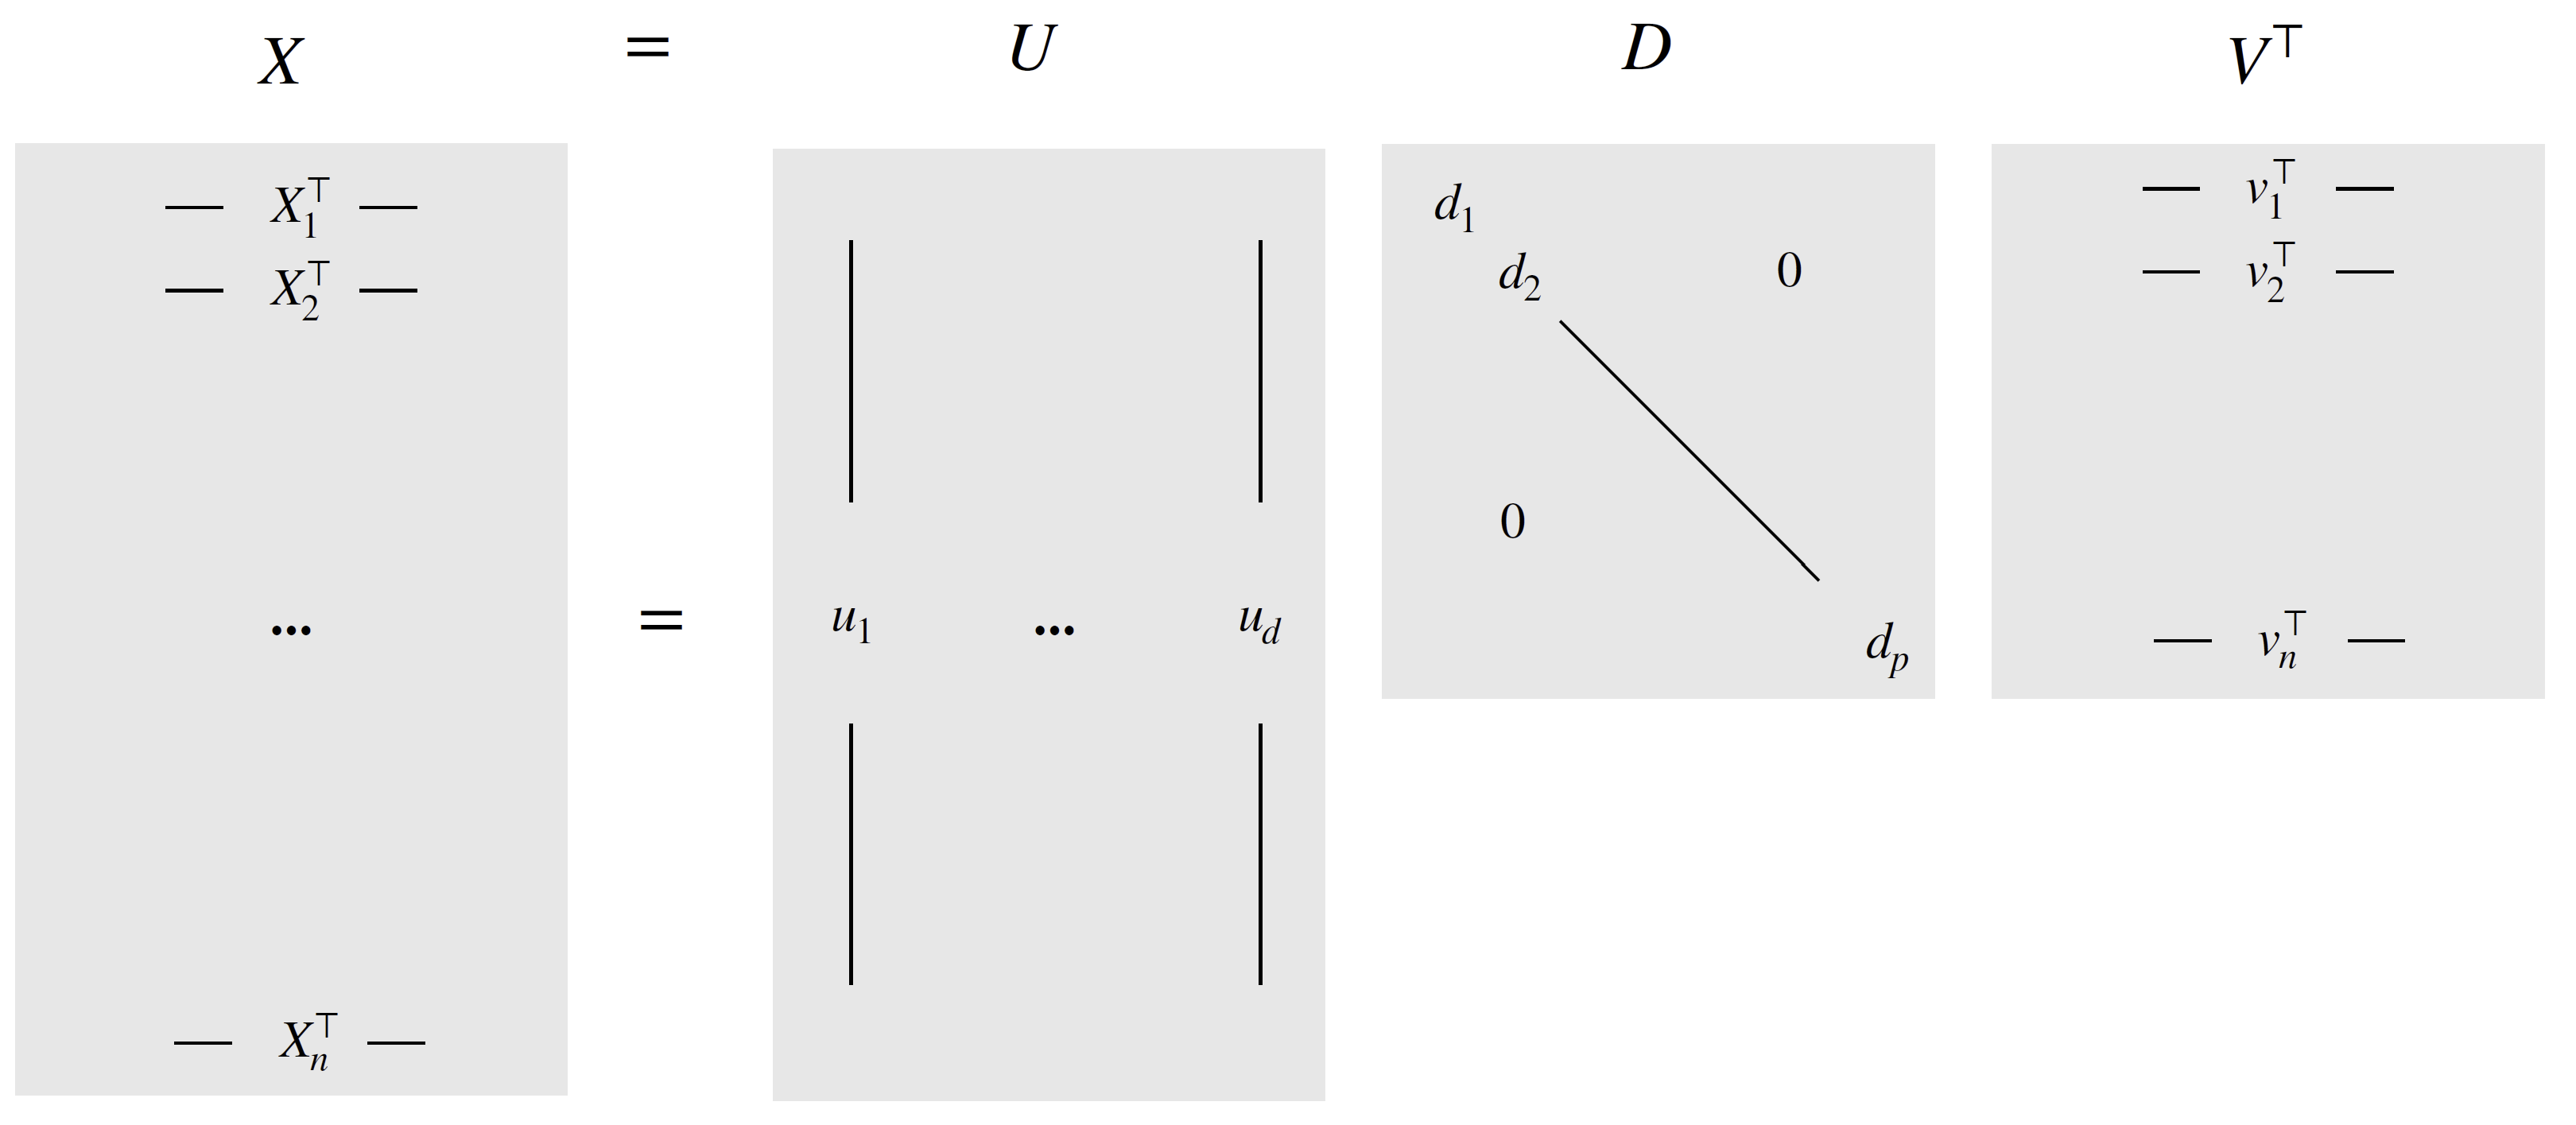

(image: Stephen Bates)

In a nutshell, we can interpret $Xw = (UDV^T)w$ as follows:
1. put $w$ in $V$ basis by computing $V^Tw$
2. scale entry $j$ by $d_j$
3. output in $U$ basis

So why would that matter for PCA? Well, remember that we're trying to solve the following problem to find $V_1, V_2, ..., V_k$:

$$\min_{V_1,...,V_k, \{w_i\}}\sum_{i=1}^n ||X_i-[V_1,...,V_k]w_i||^2,$$

which are the $k$ directions in $\mathbb{R}^d$ that summarize the data as well as possible. The notation isn't a coincidence, as it turns out that the solution $V_1,...,V_k$ is the same as the first $k$ columns of V from SVD!

The corresponding columns in $UD$ are called the principal components of $\mathbb{X}$.

**Note.** we first need to center the matrix $\mathbb{X}$ so that each column has mean 0. From now on, we will assume that this assumption holds.

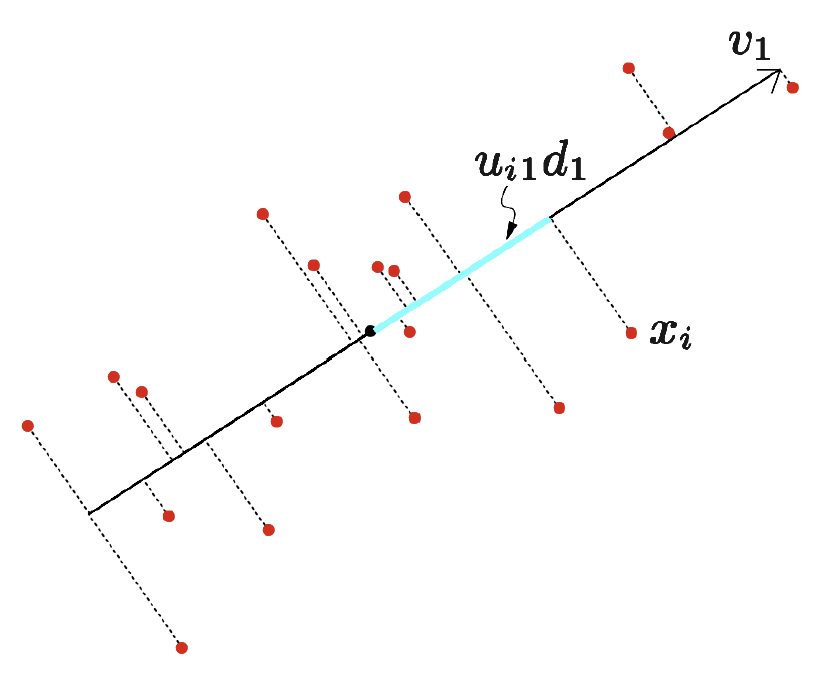

(image: Hastie, Tibsgirani, Friedman)

🟢 ***(Optional) How Do We Compute SVD?***


---

Suppose $n>d$. Then:

$$\mathbb{X}^T\mathbb{X}=(UDV^T)^T(UDV^T)=VDU^TUDV^T=VD^2V^T,$$

which is the eigendecomposition of $\mathbb{X}^T\mathbb{X}$. So we can compute the eigendecomposition of $\mathbb{X}^T\mathbb{X}$ to get $D$ and $V$ and then solve for $U$.


⚫ ***Coding Task***


---

In the code cells below we provided a scaffold for computing and visualizing the PCA of molecules that satisfy the Lipinski Rule of 5 from the ChEMBL database. Complete the TODO's according to the theory that we covered above and visualize your results by passing your data-frame to the `plot_pca_components ` function. Don't make any additional imports. You may use all the libraries that are already being imported (for example, you might find methods such as `np.linalg.svd` to be heplful).

**Hint. ** Don't forget that the principal components are given by the columns of $V$ in the SVD. However, we want to visualize the projection of the datapoints on these principal components, and not the principal components themselves. What should the `pca_svd` function return?



In [ ]:
def standardize_data(data):
  """
  Centers and scales the data, so that each feature has a mean of 0 and standard deviation of 1.

  Args:
    data: The input data (before standardization). (numpy.ndarray)

  Returns:
    The standardized data. (numpy.ndarray)
  """
  # TODO
  # Complete the function. Hint: consider using some numpy metods such as np.std()

def pca_svd(data, num_components):
  """
  Performs PCA using Singular Value Decomposition (SVD).

  Args:
    data: The input data (before standardization). (numpy.ndarray)
    num_components: The number of principal components to keep. (int)

  Returns:
    Transformed data projected to the principal component space. (numpy.ndarray)
  """

  # TODO
  # Complete the function

In [ ]:
# Query ChEMBL for Lipinski's Rule of Five compliant compounds
molecule = new_client.molecule
filters = {
    'molecule_properties__mw_freebase__lte': 500,  # Molecular weight <= 500
    'molecule_properties__hbd__lte': 5,           # No. of H-bond donors <= 5
    'molecule_properties__hba__lte': 10,          # No. of H-bond acceptors <= 10
    'molecule_properties__alogp__lte': 5          # LogP <= 5
}
molecules = molecule.filter(**filters)[:1000]  # Adjust as needed

# Extracting data, this step might take about 1 minute
data = []
for mol in molecules:
    props = mol['molecule_properties']
    if props:
        data.append([float(props['mw_freebase'] or 0), float(props['hbd'] or 0), float(props['hba'] or 0), float(props['alogp'] or 0)])

# Convert to DataFrame
df_lipinski = pd.DataFrame(data, columns=['mw', 'hbd', 'hba', 'logp'])
df_lipinski = standardize_data(df_lipinski)


num_datapoints, num_features = df_lipinski.shape
print("Number of datapoints:", num_datapoints)
print("Number of features:", num_features)

In [ ]:
num_components = 2
pca_result = pca_svd(df_lipinski, num_components)
df_pca = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(num_components)])
print(df_pca)

In [ ]:
def plot_pca_components(df_pca):
  """
  Plots the first two PCA components from a DataFrame.

  Args:
    df_pca: DataFrame containing PCA components. (pandas.DataFrame)
  """
  plt.figure(figsize=(8, 6))
  plt.scatter(df_pca['PC1'], df_pca['PC2'])
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.title('PCA Projection of the Sub-Sampled ChEMBL Dataset')
  plt.grid(True)
  plt.show()

plot_pca_components(df_pca)

🟠***But Why Does PCA Work?***



---

PCA allows us to observe [1]:

1. A measure of how each variable is associated with one another. ( The covariance matrix $\mathbb{X}^T\mathbb{X}$.)

2. The directions in which our data are dispersed. (Eigenvectors.)

3. The relative importance of these different directions. (Eigenvalues.)


⚫ ***Coding Task***


---

Let's make sure that PCA works. Complete the `calculate_covariance_matrix` and `get_eigenvalues` functions below. Make no additional imports. You may find built in functions like `np.linalg.eig` to be useful. Then, run the rest of the code boxes and visualize the results. Do they make sense?

In [ ]:
def calculate_covariance_matrix(data):
  """
  Calculates the covariance matrix for the given data.
  Args:
    data: The input data. (numpy.ndarray)

  Returns:
    The covariance matrix of the data. (numpy.ndarray)
  """
  # TODO
  # Complete the function

def get_eigenvalues(df):
  """
  Calculates the eigenvalues from the dataset for PCA.

  Args:
    df: The input DataFrame. (pandas.DataFrame)

  Returns:
    Array of eigenvalues. (numpy.ndarray:)
  """
  # TODO
  # Complete the function

In [ ]:
def plot_var(eigenvalues):
  """
  Shows the proportion of variance explained by each principal component
  and connects the cumulative variance points with a line.

  Args:
    eigenvalues: Array of eigenvalues from PCA. (numpy.ndarray)
  """
  total = sum(eigenvalues)
  var_exp = [(i / total) for i in sorted(eigenvalues, reverse=True)] # Calculates proportion of variance

  cum_var_exp = np.cumsum(var_exp) # Calculates cumulative variance

  # Plotting
  plt.figure(figsize=(10, 5))
  plt.bar(range(1, len(var_exp) + 1), var_exp, alpha=0.5, align='center', label='Individual explained variance')
  plt.plot(range(1, len(cum_var_exp) + 1), cum_var_exp, 'o-', color='r', label='Cumulative explained variance')
  plt.scatter(range(1, len(cum_var_exp) + 1), cum_var_exp, color='r')
  plt.ylabel('Explained variance ratio')
  plt.xlabel('Principal component index')
  plt.legend(loc='best')
  plt.tight_layout()
  plt.show()

In [ ]:
eigenvalues = get_eigenvalues(df_lipinski)
plot_var(eigenvalues)

⚫ ***Coding Task***


---

Finally, while the exercises above were instructive, let's make sure that you know how to calculate the PCA using a state-of-the-art package like scikit-learn. Run the code below and make sure that you understand it. Compare the results to those that we calculated and visualized above. Do you notice any differences?


In [ ]:
from sklearn.decomposition import PCA

# Standardize the data
df_standardized = standardize_data(df_lipinski)

# Initialize PCA and specify the number of components (you can always adjust the number of components as needed)
pca = PCA(n_components=2)

# Fit PCA on the standardized data
pca_result = pca.fit_transform(df_standardized)

# Convert to DataFrame for easier visualization
df_pca_sklearn = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Display the first few rows
print(df_pca_sklearn)

In [ ]:
plot_pca_components(df_pca_sklearn)

🟢 ***(Optional) Principal Curves and Surfaces***

---

It's also possible to generalize the concept of prinicipal components from a projection on a line to a projection on a smooth curve/surface.

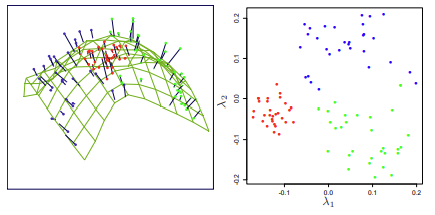

(image: Hastie, Tibshirani, Friedman)

# 3. Feature Selection





🟠 ***Introduction to Feature Selection***

---

PCA allows us to observe "directions that best describe the data". However, sometimes this may be misleading. For example, consider the example below for **Simpson's paradox**.

Therefore, sometimes we might want to **examine the features directly**. Feature selection methods play an important role in the **interpretability phase** of machine learning and molecular design projects.

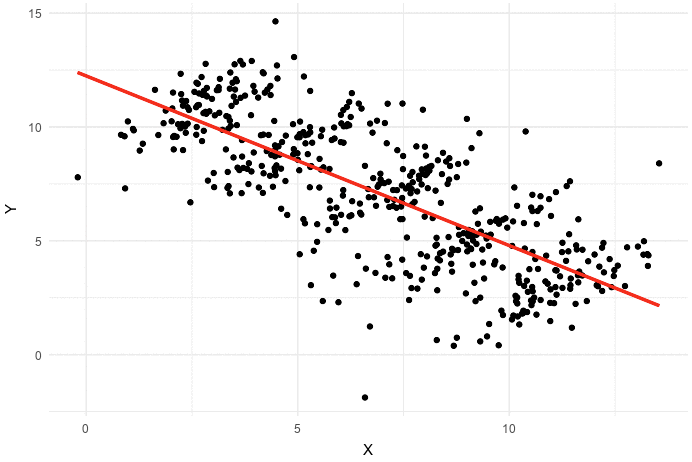

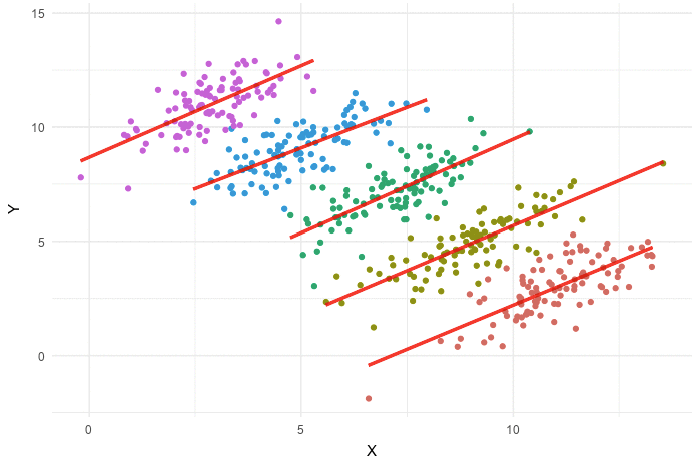

(images: [source](https://en.wikipedia.org/wiki/Simpson's_paradox))

In the following illustrations we will look at two methods for feature selection. The explanations and tutorials are taken from the [Scikit-Learn chatper for feature selection](https://scikit-learn.org/stable/modules/feature_selection.html), and you read it to learn more methods!

🟠 ***Variance Thresholding***

---
This is a simple baseline approach to feature selection. It removes all features whose variance doesn't meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is given by

$$Var(X) = p(1-p)$$

so we can select using the threshold `0.8 * (1 - 0.8)`:

In [ ]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

As expected, VarianceThreshold has removed the first column, which has a probability grater than 0.8 of containing a zero.

🟠 ***Univariate Feature Selection***

---
Univariate feature selection evaluates each feature independently to determine the strength of the relationship of the feature with the response variable. It's termed "univariate" because it looks at each feature (variable) one at a time, as opposed to multivariate methods that consider the joint effect of multiple features.

The process involves statistical tests that measure the significance of the relationship between each feature and the target variable. Common tests include:

* Chi-squared test: for categorical features.
* F-test: for numerical features with a categorical target.
* Mutual Information: for both categorical and continuous features.

Based on these tests, each feature receives a score. `SelectKBest` then selects the top $k$ features with the highest scores, and `SelectPercentile` selects the top percentage. There are also methods to control for error rates like false discovery rate.

This selection is often used as a preprocessing step to improve the performance of estimators by eliminating less important features.


In [ ]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
X, y = load_iris(return_X_y=True)
print('Original shape: ', X.shape)

X_new = SelectKBest(f_classif, k=2).fit_transform(X, y)
print('Shape after eliminating 2 of the less important features: ', X_new.shape)

# 4. t-SNE (t-Distributed Stochastic Neighbor Embedding), Nonlinear Dimension Reduction

🟣 ***Example***


---


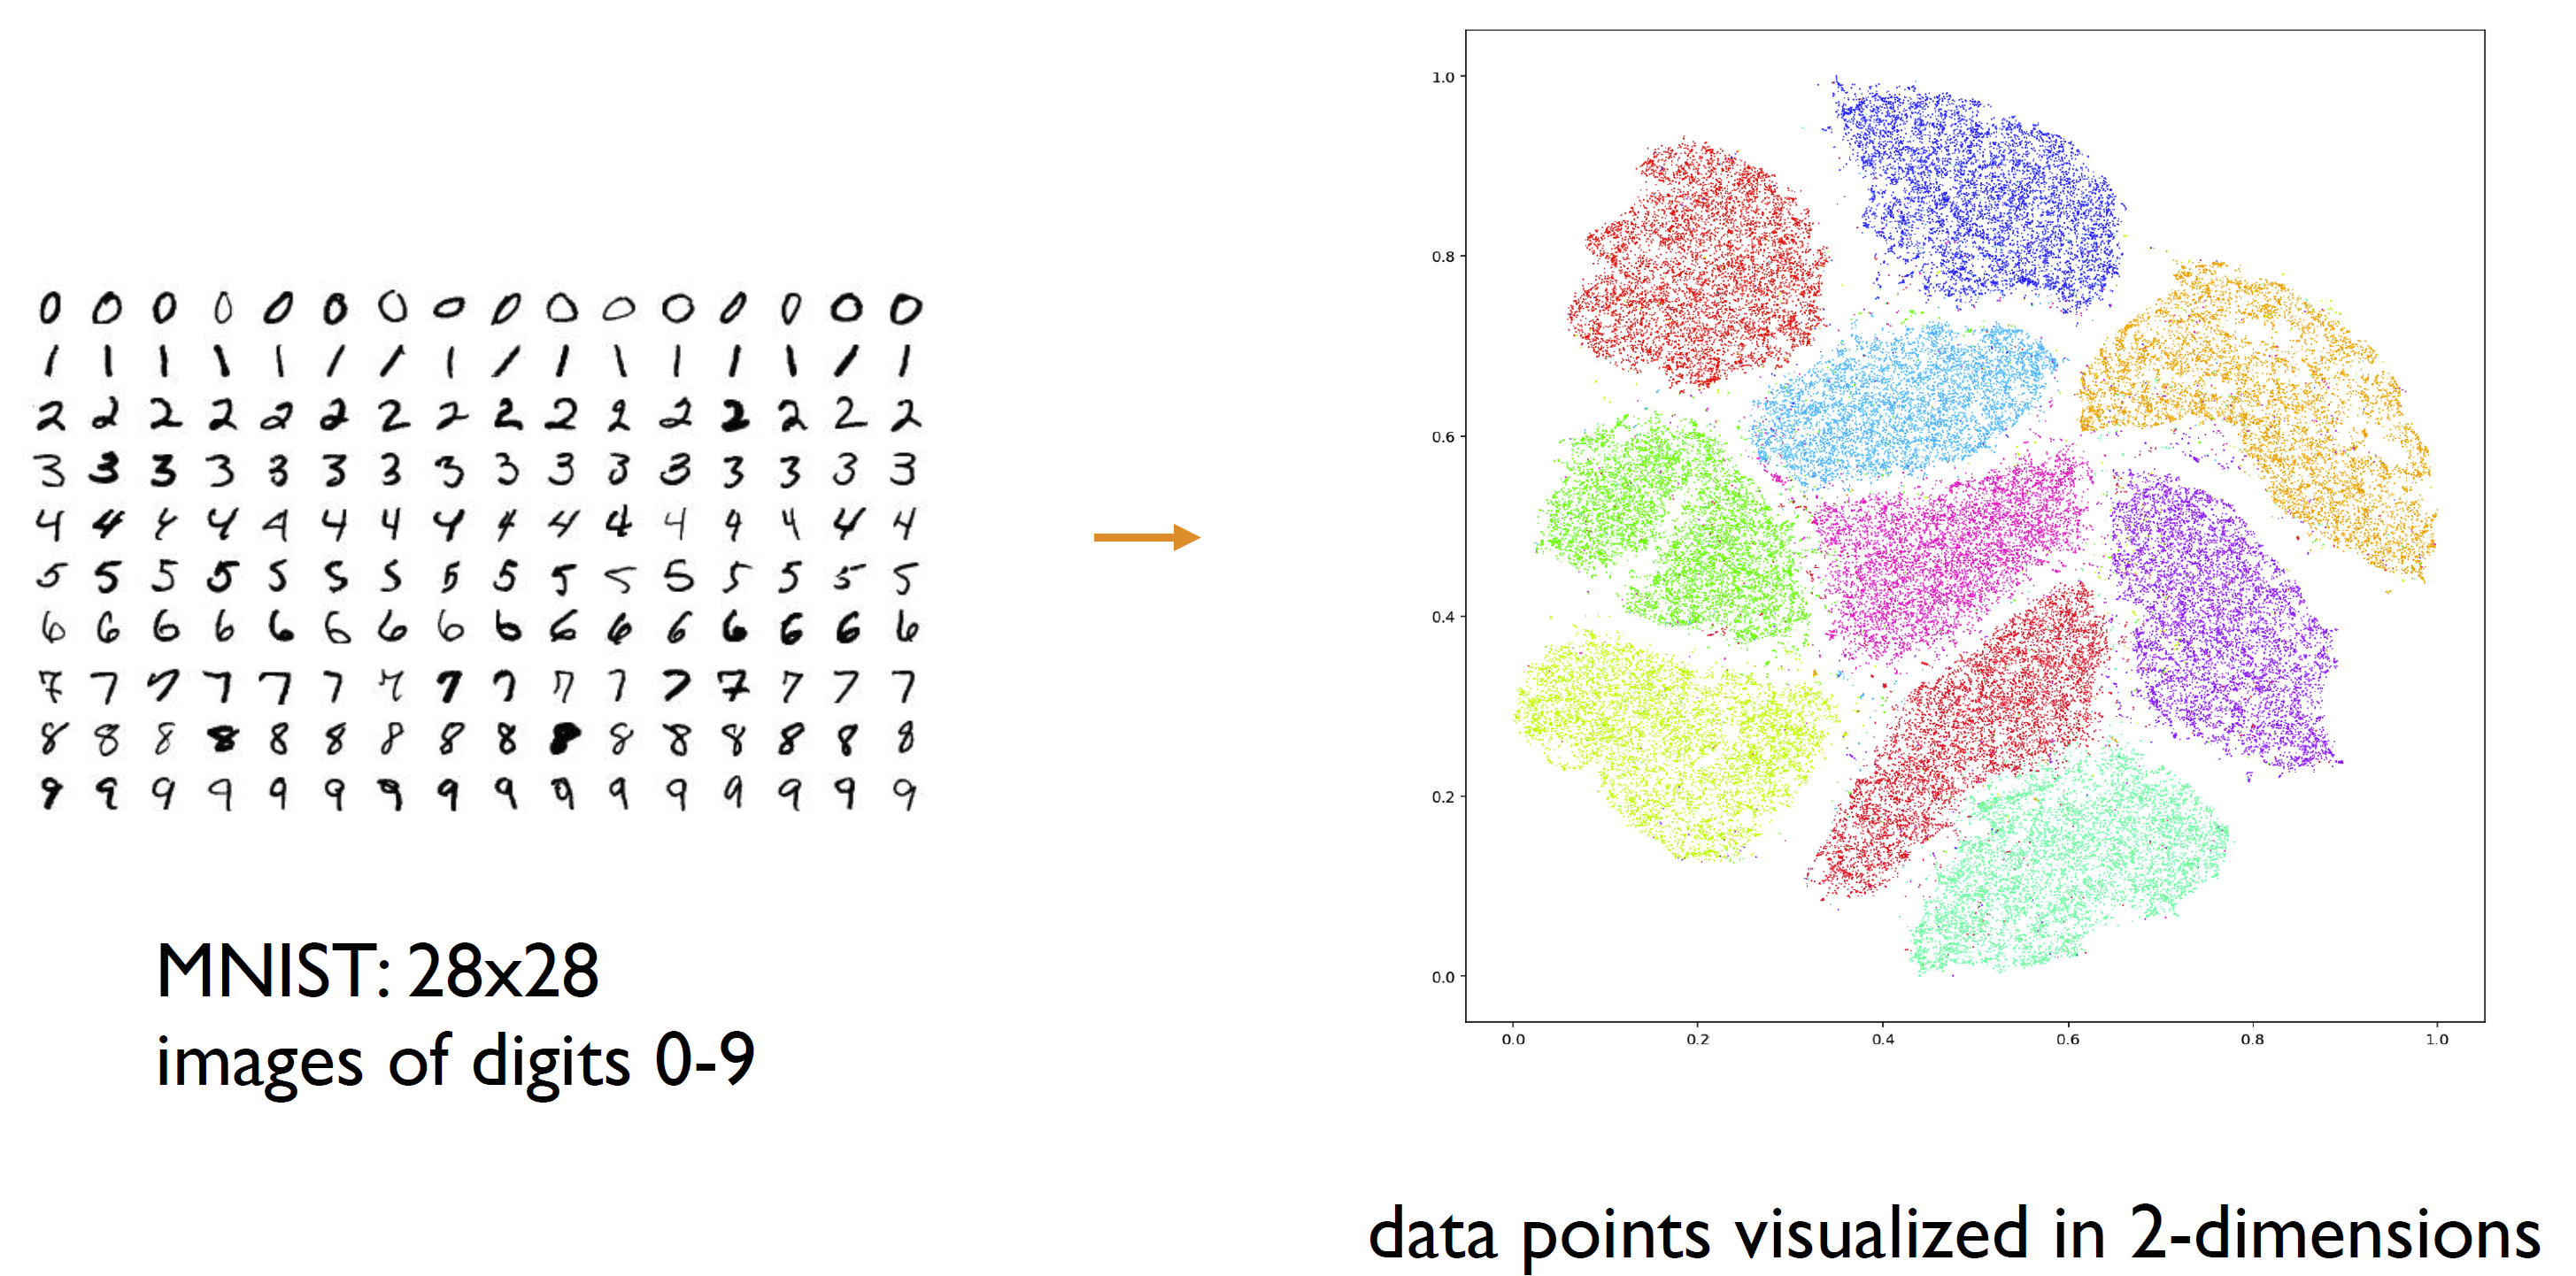

(image: Stephen Bates)

🟠 ***t-SNE Algorithm***


---
We have the same data points format $X_i\in \mathbb{R}^d$, $i = 1,...,n$ as in the PCA example. The main idea is that we find points $y_i\in \mathbb{R}^q$ such that **pairs of similar points $X_i$ and $X_j$ give close $y_i$ and $y_j$**, respectively.

To do this, we need some metric of how points are close together in $\mathbb{R}^d$ and in $\mathbb{R}^q$. Consider the following:

$$p_{j|i} = \frac{e^{-||x_i-x_j||^2/2\sigma_i^2}}{\sum_{k\neq i}e^{-||x_i-x_k||^2/2\sigma_i^2}}$$

You can think of $p_{j|i}$ as  "The similarity of datapoint $x_{j}$ to datapoint $x_{i}$ is the conditional probability, $p_{j|i}$, that $x_{i}$ would pick $x_{j}$ as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian centered at $x_{i}$" [2].

Then, we set the joint probability to:

$$p_{ij} = \frac{p_{i|j}+p_{j|i}}{2n}$$

Finally, we define the joint probabilities for the $y_i$'s:

$$q_{ij} = \frac{(1+||y_i-y_j||^2)^{-1}}{\sum_{k}\sum_{l\neq k}(1+||y_k-y_l||^2)^{-1}}$$


The goal is to minimize the loss $KL(P||Q) = \sum_{i\neq j} p_{ij}\log\left(\frac{p_{ij}}{q_{ij}}\right)$ over the $y_i$'s with gradient descent.

🟠 ***Perplexity***


---

Recall the formula for $p_{j|i}$. How do we set $\sigma_i^2$? One way is to choose $\sigma_i^2$ so that each $\{p_{j|i}\}_i$ will have a similar spread. We can do this by choosing $\sigma_i^2$ such that each $i$ has the same perplecity:

$$H(P_i) = - \sum_{j}p_{j|i}\log_2(p_{j|i})\hspace{2cm} \text{Perplexity}(P_i)=2^{H(P_i)}$$


When perplexity is set too low, **the model may become too focused on the local structure of the data**, potentially missing the broader context. This can lead to a visualization where clusters are formed based on very local relationships, possibly overstating the importance of outliers or creating many small clusters that aren't representative of the actual data structure.

On the other hand, setting the perplexity too high can make t-SNE **overly sensitive to the global data distribution**. This may cause the algorithm to overlook important local structures. As a result, different clusters in the data might be merged, or distinct local variations could be smoothed out, leading to a loss of valuable information about the data's finer structure.

The choice of perplexity is data-dependent. Generally, a perplexity value between 5 and 50 works well for most datasets, but the optimal value can vary.

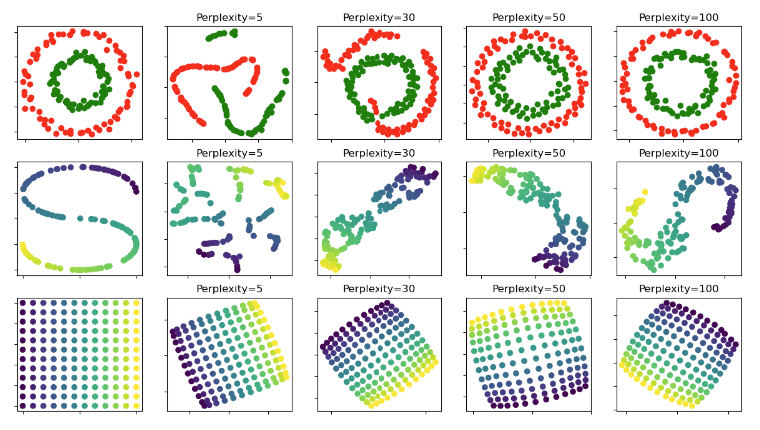

(image: [source](https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html))

🟠 ***Summary***


---

t-SNE is a useful algorithm, especially for **visualization purposes**. We discussed some guidance about tuning the $\sigma_i^2$ parameter, but the **output is usually mysterious and hard to interpret**.


⚫ ***Coding Task***


---

In this coding task we will learn how to implement t-SNE using Scikit Learn. The dataset that we will work with is the Delaney dataset from MoleculeNet:


> "The Delaney (ESOL) dataset a regression dataset containing structures and water solubility data for 1128 compounds. The dataset is widely used to validate machine learning models on estimating solubility directly from molecular structures (as encoded in SMILES strings)."

First, we will try to visualize the clusters based on different solubility values of the molecules in the dataset. We have already loaded and labeled the dataset for you. Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and generate the t-SNE visualization for the dataset by completing the TODOs in the code cells below.

In [ ]:
tasks, datasets, transformers = dc.molnet.load_delaney() # Load the dataset
train_dataset = datasets[0]

def morgan_fingerprint(smiles):
  """
  Generates the Morgan Fingerprint for a molecule.

  Args:
    smiles: the SMILES string of the molecule. (string)

  Returns:
    The Morgan Fingerprint of the input molecule. (RDKit BitVect object)
  """
  mol = Chem.MolFromSmiles(smiles)
  return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)

fingerprints = np.array([morgan_fingerprint(smile) for smile in train_dataset.ids])


🟢 ***(Optional) Morgan Fingerprints***



---

You may have noticed the `morgan_fingerprints` function in the code cell above. We are using it to take the SMILES strings of molecules in the dataset and transform them to vectors called "Morgan Fingerprints". This step is vital to many molecular design problem: **we are finding a representation of the molecules because most models can't process natural data (such as SMILES strings), they need vectors**.

Morgan fingerprints are a type of chemical fingerprint used to represent the structure of a molecule in a compact and computationally efficient format. They were developed by David Rogers and Mathew Hahn in 2010. Morgan fingerprints are widely used in cheminformatics for tasks like similarity searching, structure-activity relationship modeling, and compound classification.

We will learn more abot Morgan Fingerprints and additional representation in the next lecture!

In [ ]:
solubility = train_dataset.y.flatten()  # Here we label the samples based on their solubilities
bins = [0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, np.inf] # We use these values for different solubility values. Self criticism: are these meaningful ranges? How could you test this hypothesis?
labels = pd.cut(solubility, bins, labels=['0-0.3', '0.3-0.6', '0.6-0.9', '0.9-1.2', '1.2-1.5', '1.5-1.8', '1.8-2.1', '2.1+'])

# TODO
# Apply t-SNE
tsne_results = # Complete based on the t-SNE documentation

# Visualization with legends
plt.figure(figsize=(10, 8))
categories = labels.unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))
for i, category in enumerate(categories):
    plt.scatter(tsne_results[labels == category, 0], tsne_results[labels == category, 1],
                color=colors[i], label=category, alpha=0.7)
plt.legend() # you may ignore the nan legend
plt.title('t-SNE Visualization Based on Solubility Ranges')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()


🟡🟡🟡 Run the code cell above with the following perplexity values: 1, 10, 30, 50, 100, 200. What changes do you observe in the generated graphs? If you don't observe a meaningful clustering pattern, what might be the reason for this?

🟡🟡🟡 Answer: TODO

⚫ ***Coding Task***


---


Now let's try to run t-SNE on the same dataset, but this time we will label the molecule based on a very simple structural feature: do they have an aryl halide (if so, which one?) functional group, or not. Complete the TODOs as in the previous coding task and run the code cell to visualize the resutls.

In [ ]:
def contains_aryl_group(mol, halogen_atomic_numbers):
  """
  Checks whether a molecule has an aryl halide functional group.

  Args:
    mol: the molecule of interest. (RDKit mol object)
    halogen_atomic_numbers: a list containing the atomic number of all halogens

  Returns:
    True if the molecule has an aryl halide functional group and False otherwise.
  """
  for atom in mol.GetAtoms():
      if atom.GetAtomicNum() in halogen_atomic_numbers:
          if any(neighbor.GetIsAromatic() for neighbor in atom.GetNeighbors()):
              return True
  return False

# Labeling function
def label_molecule(smiles):
  """
  Labels molecules based on the presence of aryl halide function group(s).

  Args:
    smiles: the SMILES string of the molecule of interest. (string)

  Returns:
    A string representing the label of the molecure as described in the introduction to this coding task.
  """
  mol = Chem.MolFromSmiles(smiles)
  if contains_aryl_group(mol, [9]):  # Fluorine
      return 'Aryl fluoride'
  if contains_aryl_group(mol, [17]):  # Chlorine
      return 'Aryl chloride'
  if contains_aryl_group(mol, [35]):  # Bromine
      return 'Aryl bromide'
  if contains_aryl_group(mol, [53]):  # Iodine
      return 'Aryl iodide'
  return 'Not an aryl halide'

labels = np.array([label_molecule(smiles) for smiles in train_dataset.ids]) # Label each molecule in the dataset

# TODO
# Apply t-SNE
tsne_results = # Complete based on the t-SNE documentation

# Visualization
plt.figure(figsize=(10, 8))
categories = np.unique(labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))
for i, category in enumerate(categories):
    plt.scatter(tsne_results[labels == category, 0], tsne_results[labels == category, 1],
                color=colors[i], label=category, alpha=0.7)
plt.legend()
plt.title('t-SNE Visualization Based on Aryl Halide Labels (Solubility Dataset)')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

🟡🟡🟡 Run the code cell above with the following perplexity values: 1, 10, 30, 50, 100, 200. Which perplexity value produced the "cleanest" clustering pattern? Explain your answer.


🟡🟡🟡 Answer: TODO

🟡🟡🟡 Recall that we're still using the Delaney (solubility) dataset in this example. Compare the clustering pattern in this visualization to the plots you generated in the previous coding task. Which clustering pattern is more meaningful? Why is this happening?

🟡🟡🟡 Answer: TODO

# 5. Clustering

🟠 ***Problem Outline***


---


Clustering is one of the most popular problems in unsupervised learning. There are many perspectives to finding "coherent" groups or clusters in the data. Beyond molecular design, this is applicable to other domains, such as  image segmentation, document analysis, recommendation systems, etc.


🔴 ***K-Means Clustering Algorithm***


---

1. Randomly select cluster centers $\mu_1, ..., \mu_k$.
2. Assign each datapoint, $X_i$, to its closest cluster center (with respect to some chosen metric, for example $||\cdot||^2$).
3. Estimate new cluster centers (means) from the assigned points.
4. Iterate until convergence.

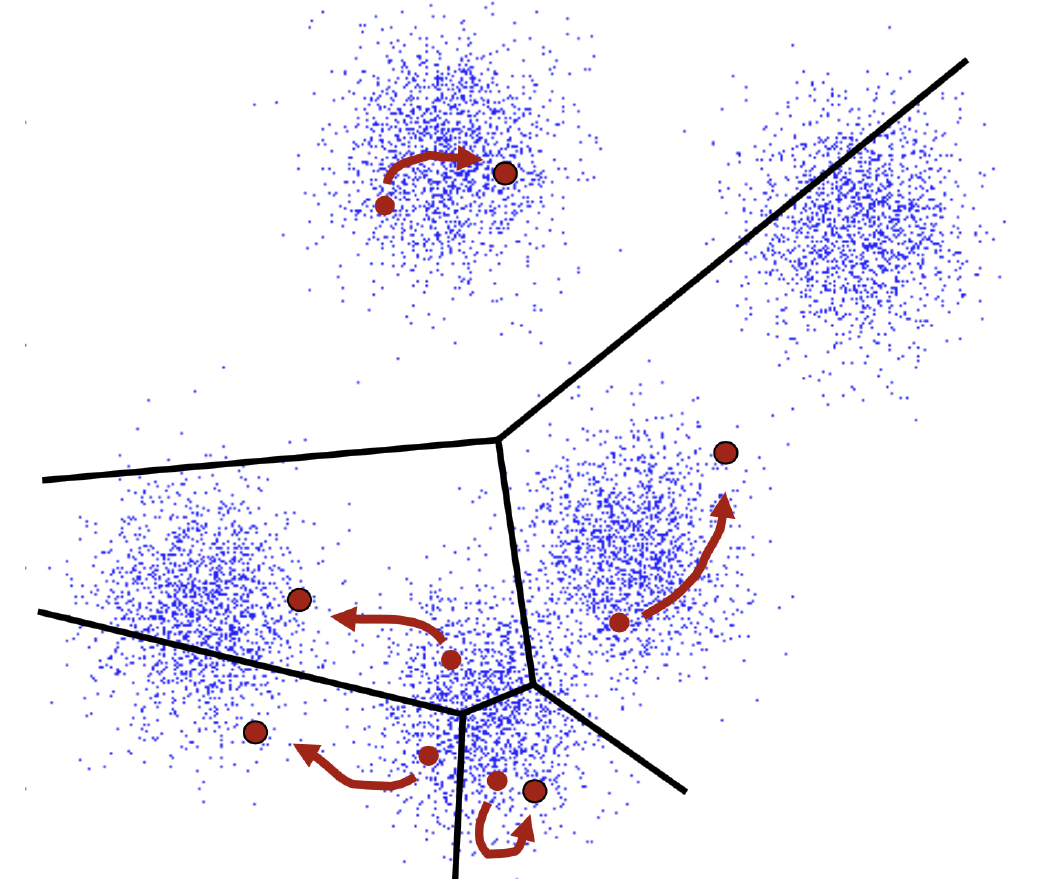


⚫ ***Coding Task***


---


This question will explore some cases in which the K-Means clustering algorithm may or may not give ideal results. All parts of this question will use squared Euclidean distance as a distance metric.

🟡🟡🟡 First, complete the following functions. You will need to implement the distance metric and the objectice function for the K-Means algorithm. It could be helpful to write down the objective function on paper first.

In [ ]:
def euclidean_distance_squared(point, centroid):
  """
  Calculates the squared Euclidean distance between a point and a centroid.

  Args:
    point: A single data point. (np.array)
    centroid: A single centroid point. (np.array)

  Returns:
    The squared Euclidean distance between point and centroid. (float)
  """
  # TODO
  # Complete the function. Hint: You may find some numpy methods to be useful

def kmeans_objective_function(data_points, centroids):
  """
  Calculates the objective function of the k-means algorithm.

  Args:
    data_points: Array of data points. (np.array)
    centroids: Array of current centroids. (np.array)

  Returns:
    Total sum of squared distances from each point to its nearest centroid. (float)
  """
  # TODO
  # Complete the function.

🟡🟡🟡 Now, let's implemen the K-Means algorithm. Complete the function `simple_kmeans` below. Notice that we are assuming that the data is two dimensional. You can see an example for how the data is generated in the `generate_gaussian_data` function below.

In [ ]:
def simple_kmeans(data, n_clusters):
  """
  Implementation of the K-Means clustering algorithm for 2D data.

  Args:
    data: 2D NumPy array of data points, each row is a point. (np.array)
    n_clusters: Number of clusters to form. (int)

  Returns:
    Tuple of (cluster labels, centroids).
  """

  centroids = data[np.random.choice(data.shape[0], n_clusters, replace=False), :]
  prev_centroids = # TODO. Initialize the list of previous centroids to be an array of zeros (before initialization there are no centroids). Hint: what should be the right dimension?
  max_iterations = 100
  for i in range(max_iterations):
      labels = np.array([np.argmin([euclidean_distance_squared(x, c) for c in centroids]) for x in data])
      for j in range(n_clusters):
          points_in_cluster = data[labels == j]
          if points_in_cluster.size > 0:
              centroids[j] = # TODO: assign the new centroid to be the mean of all te points in the cluster. Hint: np.mean could be helpful here
      if np.allclose(centroids, prev_centroids):
          # TODO: what should you do when the centroids stopped changing (i.e., the algoritm has converged)?
      prev_centroids = centroids.copy()
  return labels, centroids

🟡🟡🟡 Consider a 2D dataset generated from two Gaussian distributions $N_1(\mu_1, \sigma_1^2)$ and $N_2(\mu_2, \sigma_2^2)$. Assume the dataset contains $n$ points from each distribution for some arbitrarily large $n$.

Define thhe following clasifier: we assign a point $X_i$ to cluster 1 if the probability $N_1(X_i;\mu_1. \sigma_1^2)\geq N_2(X_i;\mu_2. \sigma_2^2)$, and to cluster 2 oterwise. This is the [Bayes Classifier](https://en.wikipedia.org/wiki/Bayes_classifier).

Consider the case where $\sigma_1^2=\sigma_2^2$. Would you expect a 2-means clustering algorithm to approximate the optimal classifier for large $n$? You can try to visualize the behavior of this classifier using your K-Means function above and the `generate_gaussian_data` and `visualize_clusters` function below.

In [ ]:
def generate_gaussian_data(mu1, mu2, sigma1, sigma2, n):
  """
  Generates 2D data from two Gaussian distributions with specified means and covariances.

  Args:
    mu1: Mean of the first Gaussian distribution. (2D np.array)
    mu2: Mean of the second Gaussian distribution. (2D np.array)
    sigma1: Covariance matrix of the first Gaussian distribution. (2x2 np.array)
    sigma2: Covariance matrix of the second Gaussian distribution. (2x2 np.array)
    n: Number of points to generate for each distribution. (int)

  Returns:
    2D np.array of generated data points, each row is a point.
  """

  data1 = np.random.multivariate_normal(mu1, sigma1, n)
  data2 = np.random.multivariate_normal(mu2, sigma2, n)
  return np.vstack([data1, data2])

def visualize_clusters(data, labels, centroids):
    """
    Visualizes the clustered 2D data with different colors for each cluster and centroids.
    Data points and centroids are np.arrays.

    Args:
      data: 2D np.array of data points, each row is a point.
      labels: np.array of cluster labels for each point in data.
      centroids: 2D np.array of centroids.
    """

    plt.scatter(data[labels == 0, 0], data[labels == 0, 1], alpha=0.5, label='Cluster 1 Samples') # Scatter plot for Cluster 1 samples
    plt.scatter(data[labels == 1, 0], data[labels == 1, 1], alpha=0.5, label='Cluster 2 Samples') # Scatter plot for Cluster 2 samples
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', label='Centroids') # Scatter plot for centroids

    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('K-Means Clustring')
    plt.legend()
    plt.show()

In [ ]:
mu1, mu2 = [0, 0], [10, 0]
sigma1, sigma2 = [[1, 0], [0, 1]], [[1, 0], [0, 1]]
n = 500

data = generate_gaussian_data(mu1, mu2, sigma1, sigma2, n)
labels, centroids = simple_kmeans(data, 2)
visualize_clusters(data, labels, centroids)

🟡🟡🟡 Answer: TODO

🟡🟡🟡 Now consider the case where $\sigma_1^2\gg \sigma_2^2$. Would you expect a 2-means clustering algorithm to approximate the optimal classifier for large $n$? You can try to visualize thhis case using the code cell below.

In [ ]:
mu1, mu2 = [0, 0], [10, 0]
sigma1, sigma2 = [[1, 0], [0, 1]], [[100, 0], [0, 10]]
n = 500

data = generate_gaussian_data(mu1, mu2, sigma1, sigma2, n)
labels, centroids = simple_kmeans(data, 2)
visualize_clusters(data, labels, centroids)

🟡🟡🟡 Answer: TODO

🟢 ***(Optional) Extension***


---

A better way to perform the clustering could be a [Gaussian Mixture Model](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95).

🟡🟡🟡 Consider a dataset with points that are outliers. Would you still expect K-Means to perform well in such a setting?

🟡🟡🟡 Answer: TODO

⚫ ***Coding Task***

---

Finally, let's see how to run K-Means with a package like Scikit-Learn:

In [ ]:
from sklearn.cluster import KMeans

X = np.array([[1, 2], [1, 4], [1, 0],
              [10, 2], [10, 4], [10, 0]]) # Sample data

k = 2 # Number of clusters

# Creating KMeans instance
kmeans = KMeans(n_clusters = k, random_state = 42)

kmeans.fit(X) # Fitting the clustering model

# Getting cluster centers and labels
centers = kmeans.cluster_centers_
labels = kmeans.labels_

print("Cluster centers:\n", centers)
print("Labels:", labels)

🟠 ***Practical Issues***

---

1. The algorithm may struggle to break symmetrical patterns in the dataset. For example, try to think what would be the result of the algorithm on the following data:

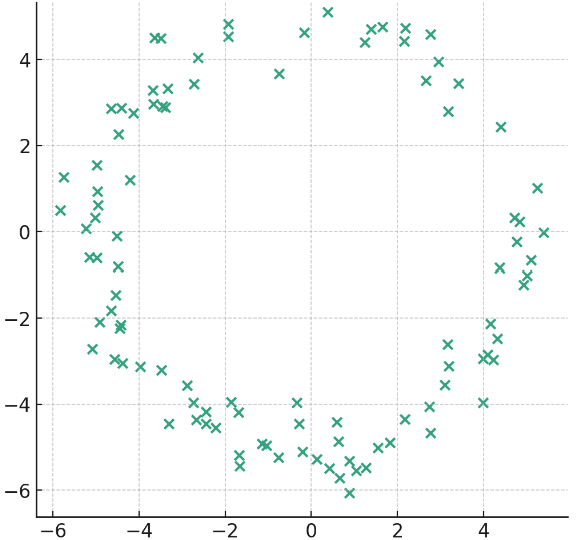

2. The results of the algorithm may change drastically as a result of the initialization method.

3. The choice for the number of clusters may depend on the goal. Sometimes, it's clear how many clusters we should choose, for example: there are $n$ experimens that should be distributed among $m$ chemists, so a reasonable choice for the number of clusters will be $m$. However, sometimes it's not clear how many clusters we should choose, as we apply the algorithm to learn different groups in the data by itself.

One way to solve this issue would be to consider the within cluster dissimilarity $W_K$ as a function of the number of clusters $K$. We expect the score to decrease as $K$ increases with the special relationship:

$$\{W_K-W_{K-1}|K<K^*\} \gg \{W_K-W_{K-1}|K\geq K^*\},$$

, where $K^*$ can be interepreted as the ground truth number of clusters/optimal number of clusters.


🟢 ***(Optional) Self-Organizing Maps***

---

The algorithm can be thought of an iterative version of K-Means where the clusters are bound together to form a one or two dimensional manifold in the feature space. Every time on of the clusters is adjusted, the other clusters change their positions as well. The resulting manifold serves as a map between the high dimensional feature space to a lower dimension

🟠 ***Hierarchical Clustering***


---

Sometimes the data isn't partitioned into obvious disjoint groups. In this cases, we want to get coherent information across many resolutions.

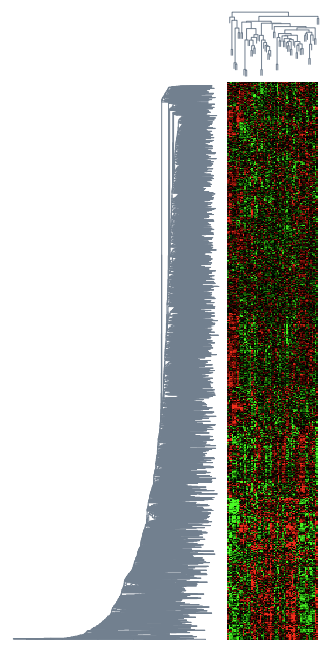

(image: Hastie, Tibshirani, Friedman)

🔴 ***Hierarchical Clustering Algoritm***


---

1. Start with every point in its own cluster
2. At each step, merge two "closest" clusters

But what does "closest" mean?

Let $G$ and $H$ be two groups of data points. Te distance between points $x_i$ and $x_j$ can be:



*   Single linkage: $D_{SL}(G,H)= \min_{x_i\in G, x_j\in H}d(x_i, x_j)$
*   Complete linkage: $D_{CL}(G,H)= \max_{x_i\in G, x_j\in H}d(x_i, x_j)$
*   Average linkage: $D_{avg}(G,H)= \frac{1}{|G|\cdot |H|}\sum_{x_i\in G, x_j\in H}d(x_i, x_j)$

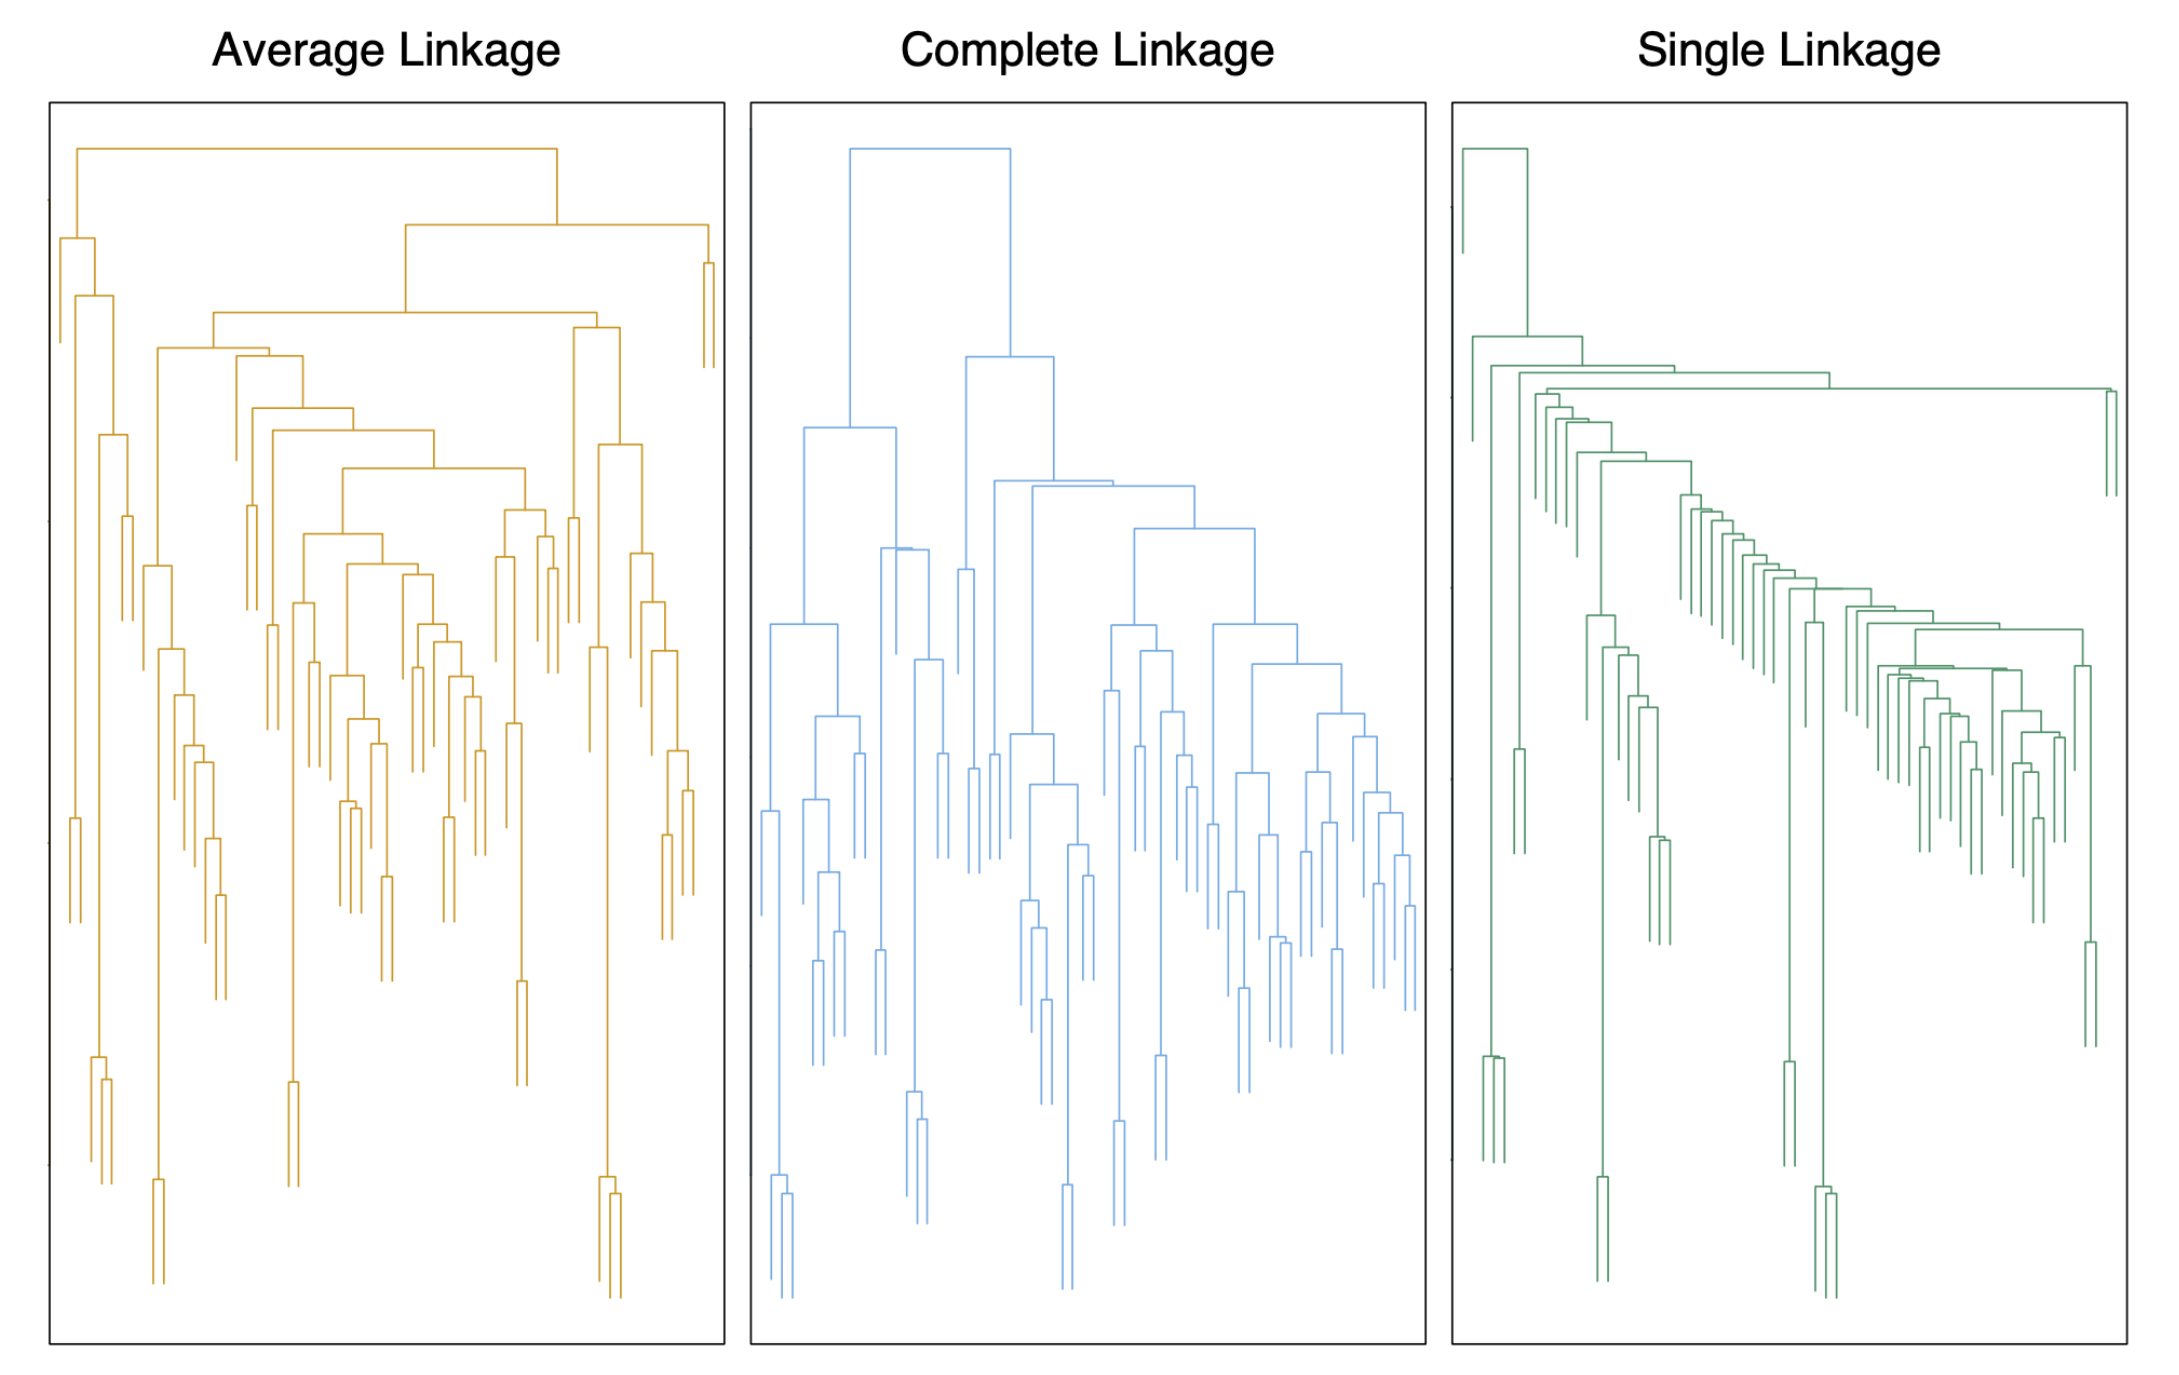

(image: Hastie, Tibshirani, Friedman)


# 6. Research Problem

⚫ ***Coding Task***

---
The prediction of reaction yield in chemistry is crucial as it guides the efficient use of resources, reduces waste, and optimizes chemical processes. Accurately predicting yields is challenging due to the complex nature of chemical reactions, which are influenced by a myriad of factors such as reactant properties, catalysts, temperature, pressure, and solvents. The complexity is compounded by the unpredictable interactions among these factors. This makes yield prediction a hard task, requiring a deep understanding of chemistry, extensive experimental data, and often, advanced computational techniques to model and predict the outcomes of chemical reactions.

The purpose of this coding task is to give you an oppurtunity to examine real datasets that are used in molecular design. In particular, we will examine datasets from [Therapeutics Data Commons](https://tdcommons.ai/) that are related to the yield prediction problem:

* [Buchwald-Hartwig dataset](https://tdcommons.ai/single_pred_tasks/yields/) that has 55,370 reactions labeled by their yield.

* The full [USPTO](https://tdcommons.ai/single_pred_tasks/yields/) (United States Patent and Trademark Office) dataset. This dataset is much larger and it contains 853,638 reactions.


While they are more commonly used for yield prediction (given reactant and product set $X$, predict the yields $Y$), we will only conduct a superficial analysis. You are welcome to try and apply some machine learning analysis, but we will only learn how to do that in the next lecture.

Let's get started!

In [ ]:
!pip install PyTDC # Installing the TDC package

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tdc.single_pred import Yields
data = Yields(name = 'USPTO_Yields')
split = data.get_split() # This will give to a training, validation, adn test splits of the dataset. It's
                         # very useful for machine learning analysis, but we will combine the data later on

🟡🟡🟡 First, let's look at the data. You can  try the following: print it, convert it to a pandas dataframe, understand it's data structure. You will have to analyze it so you should familiarize yourself with the different aspects of the dataset.

In [ ]:
# TODO: understand the structure of the dataset!

🟡🟡🟡 In the code below we formed a single dataframe for the entire dataset for you. Pandas dataframe are very easy to work with! For example, you can call `combined_df['Y'].describe()` to get some statistics on the yield values in the dataset. Do you notice something strange about these values. Comment on them below.

In [ ]:
train_df = split['train']
valid_df = split['valid']
test_df = split['test']

combined_df_uspto = pd.concat([train_df, valid_df, test_df], ignore_index=True) # Concatenating them into one DataFrame

In [ ]:
# TODO: get yield statistics

🟡🟡🟡 Answer [USPTO yield statistics]:

🟡🟡🟡 After understanding the different patterns in the dataset you can try to clean the data. Usually, this is a very important pre-processing step as many experimental datasets are quite noisy. You may choose any strategy: keep values that are between 0 and 1, constrain the standard deviation, etc. In particular, we would recommend you to only keep values between 0 to 1. This is a reasonable strategy as most chemical reactions have yield values in this range. Usually, you don't want to use a cleaning strategy that is too conserative because this will induce biases to your dataset, which will be reflected in the final results.

Convert you cleaned dataset to a pandas dataframe `cleaned_df` and then run the code cell below to visualize the yield distribution. Do you notice any patterns?

In [ ]:
cleaned_df = # TODO: Filter the DataFrame

# Plotting the histogram for the cleaned data
plt.figure(figsize=(10, 6))
plt.hist(cleaned_df['Y'], bins=50, range=(0,1), color='blue', alpha=0.7) # change the range if you expect values that are outside the [0, 1] interval
plt.title('Histogram of Reaction Yields)')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

🟡🟡🟡 Answer [patterns in the cleaned dataset]:

🟡🟡🟡 From now on, let's work with the Buchwald-Hartwig dataset that has a cleaner yield distribution. We have imported it for you. Inspect it!

In [ ]:
from tdc.single_pred import Yields
data = Yields(name = 'Buchwald-Hartwig')
split = data.get_split() # This will give to a training, validation, adn test splits of the dataset. It's
                         # very useful for machine learning analysis, but we will combine the data later on

In [ ]:
combined_df['Y'].describe()

In [ ]:
# Plotting the histogram for the cleaned data
plt.figure(figsize=(10, 6))
plt.hist(combined_df['Y'], bins=50, range=(0,1), color='blue', alpha=0.7)
plt.title('Histogram of Reaction Yields)')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

🟡🟡🟡 Now, let's visualize the dataset. In the code below we have provided an example for how to encode a reaction SMILES string. We will talk about it more detail in the next lecture. The `create_reaction_smiles` function constructs reaction SMILES string for each row in the dataset, that has sets of reactions and products. The `compute_morgan_fingerprint` function encodes the reaction. We have provided the code for how to call these functions. The encoded reactions are now stored at `combined_df['Morgan_FP']`.

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [ ]:
# Example for how to encode a reaction SMILES string using Morgan fingerprints

rxn = 'FC(F)(F)c1ccc(Cl)cc1.Cc1ccc(N)cc1.O=S(=O)(O[Pd]1c2ccccc2-c2ccccc2N~1)C(F)(F)F.CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.c1ccc(-c2ccno2)cc1>>Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1'
settings = rdChemReactions.ReactionFingerprintParams(False,0.2,10,1,64, rdChemReactions.FingerprintType.MorganFP)
reaction = rdChemReactions.ReactionFromSmarts(rxn)
bits = rdChemReactions.CreateStructuralFingerprintForReaction(reaction,settings) # The reaction fingerprint

In [ ]:
def create_reaction_smiles(row):
  """
  Generates a reaction SMILES string from reaction components.

  This function constructs a reaction SMILES string from the reactants, product, and catalyst
  information present in a given row of a DataFrame. The catalyst is included in the reaction
  SMILES only if it is present.

  Arguments:
    row: A row from a DataFrame containing the 'Reaction' key with 'reactant',
                    'product', and 'catalyst' as sub-keys. (pd.Series)

  Returns:
    A SMILES string representing the chemical reaction.
  """

  reactants = row['Reaction']['reactant']
  product = row['Reaction']['product']
  catalyst = row['Reaction']['catalyst']

  if catalyst:
    reaction_smiles = f"{reactants}.{catalyst}>>{product}"
  else:
    reaction_smiles = f"{reactants}>>{product}"
  return reaction_smiles



def compute_morgan_fingerprint(smiles, radius=2, n_bits=2048):
  """
  Computes the Morgan fingerprint of a reaction given its SMILES string.

  This function generates a Morgan fingerprint for a chemical reaction. The fingerprint is
  computed based on the provided SMILES string using RDKit's functionalities.

  Arguments:
    smiles: A SMILES string representing the chemical reaction.
    radius: The radius parameter for the Morgan fingerprint. Defaults to 2. (int)
    n_bits: The number of bits in the fingerprint. Defaults to 2048. (int)

  Returns:
    The computed Morgan fingerprint as an RDKit BitVect object.
  """

  settings = rdChemReactions.ReactionFingerprintParams(False,0.2,10,1,n_bits, rdChemReactions.FingerprintType.MorganFP)
  reaction = rdChemReactions.ReactionFromSmarts(smiles)
  return rdChemReactions.CreateStructuralFingerprintForReaction(reaction, settings)

In [ ]:
combined_df['Reaction_SMILES'] = combined_df.apply(create_reaction_smiles, axis=1) # Create reaction SMILES

combined_df['Morgan_FP'] = combined_df['Reaction_SMILES'].apply(compute_morgan_fingerprint) # Compute Morgan fingerprints

In [ ]:
combined_df['Morgan_FP']

🟡🟡🟡 Visualize the encoded reaction space using some visualization method of your choice. You may use PCA, t-SNE, or any other method that you are familiar with. Your goal is to visualize the dataset in some meaningful manner and explore any possible clustering patterns.

In [ ]:
fp_matrix = np.array(combined_df['Morgan_FP'].tolist())

dim_reduction_results = # TODO: Visualize the dataset using some method of your choice.

# Plotting
plt.figure(figsize=(10, 8))
sc = plt.scatter(dim_reduction_results[:, 0], dim_reduction_results[:, 1], c=combined_df['Y'], cmap='viridis')
plt.colorbar(sc)
plt.title('Dimensionality Reduction Visualization of Morgan Fingerprints Colored by Yield')
plt.xlabel('Dimensionality reduction component 1')
plt.ylabel('Dimensionality reduction component 2')
plt.show()

🟡🟡🟡 A helpful heuristic that is very common in visualization, and machine learning problem more boradly, is "to make the task simpler". In this example, we are mainly interested to learn the difference between reactions with "high yield" to those with "low yield". The `categorize_yield` function below defines 50% as the threshold between "high" and "low" yield. Of course, this definition is rather subjective because in some circumstances a reaction with 40% yield could be considered successful. However, run the code below using the computed dimensionality reduction results (`dim_reduction_results`) you obtained aboce. Does it help you to make a clearer distinction?

In [ ]:
def categorize_yield(y):
  """
  Categorize the chemical reaction yield into predefined classes.

  This function categorizes the yield of a chemical reaction into two classes: '0-0.5' and
  '0.5-1', based on the value of the yield.

  Arguments:
    y: The yield of the chemical reaction. (float)

  Returns:
    A string indicating the yield category ('0-0.5' or '0.5-1').
  """

  if y < 0.5:
      return '0-0.5'
  else:
      return '0.5-1'

combined_df['Yield_Category'] = combined_df['Y'].apply(categorize_yield)

# Plotting
plt.figure(figsize=(10, 8))
categories = combined_df['Yield_Category'].unique()
colors = ['red', 'green', 'blue']
for category, color in zip(categories, colors):
    indices = combined_df['Yield_Category'] == category
    plt.scatter(dim_reduction_results[indices, 0], dim_reduction_results[indices, 1], c=color, label=category)
plt.title('Dimensionality Reduction Visualization of Reaction Morgan Fingerprints')
plt.xlabel('Dimensionality reduction component 1')
plt.ylabel('Dimensionality reduction component 2')
plt.legend()
plt.show()


🟡🟡🟡 Finally, let's try to analyze what the the top 10 bits that differ between reactions with high yield (50-100%) to reactions with low yield (0-50%). For this we will use the `SelectKBest` method from SciKit-Learn with the Chi Squared test (`chi2`). Complete the TODO's below to get the bit indices. We will learn how to go back to the structural elements in the next lecture!

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# Filter the dataset for each category
low_yield_data = fp_matrix[combined_df['Yield_Category'] == '0-0.5']
high_yield_data = fp_matrix[combined_df['Yield_Category'] == '0.5-1']

low_yield_labels = np.zeros(low_yield_data.shape[0])
high_yield_labels = np.ones(high_yield_data.shape[0])

# Combine the datasets, your task is to get the appropriate matrices
X = np.vstack(# TODO)
y = np.hstack(# TODO)

selector = SelectKBest(chi2, k=10) # Feature selection
selector.fit(X, y)

top_features = selector.get_support(indices=True) # Get the indices of the selected features

print("Indices of top 10 significant bits:", top_features)

# References

1. Brems M., "A One-Stop Shop for Principal Component Analysis, in
Towards Data Science, 2017.

2. Van der Maaten L.J.P., Hinton, G.E., "Visualizing Data Using t-SNE", in the Journal of Machine Learning Research. 9: 2579-2605, 2008.

3. Hastie T., Tibshirani R., Friedman J., "The Elements of Statistical Learning", Springer, 2017.

# Acknowledgments



Some material is inspried by Prof. Stephen Bates lecture on unsupervised learning at 6.7900.